In [3]:
from warnings import filterwarnings
import json
import re
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.base import clone
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV, KFold

# модули для работы с текстом
import pymorphy2
from sklearn.feature_extraction.text import CountVectorizer
from stop_words import get_stop_words
import gensim.downloader as api

from tqdm import tqdm
tqdm.pandas()

sns.set()

In [4]:
RANDOM_SEED = 42

In [6]:
DATA_SF_PATH = "data/"
ADD_DATA_PATH = "data/"

In [133]:
# загрузим тестовую и обучающую выборки
df_test = pd.read_csv(DATA_SF_PATH + "test.csv")
df_train = pd.read_csv(ADD_DATA_PATH + "train.csv")

In [86]:
df_test.shape, df_train.shape

((34686, 32), (55683, 28))

## Приведем в соответствие тестовую и обучающую выборки

In [134]:
# удалим те колонки, которых нет в обучающей выборке
cols_to_drop = ["complectation_dict", "image", "modelDate",
                "model_info", "vehicleConfiguration"]
df_test.drop(cols_to_drop, axis=1, inplace=True)

In [135]:
# приведем названия колонок к единому формату: col_name
mapper = {
    "bodyType": "body_type",
    "engineDisplacement": "engine_displacement",
    "enginePower": "engine_power",
    "fuelType": "fuel_type",
    "numberOfDoors": "number_of_doors",
    "priceCurrency": "price_currency",
    "productionDate": "production_year",
    "vehicleTransmission": "vehicle_transmission",
    "Владельцы": "owners",
    "Владение": "ownership",
    "ПТС": "vehicle_passport",
    "Привод": "drive",
    "Руль": "steering_wheel",
    "Состояние": "condition",
    "Таможня": "customs"
}
df_test.rename(mapper, axis=1, inplace=True)

In [136]:
# сконвертируем equipment_dict в список и переименуем
def convert_equipment_str_to_list(s):
    d = json.loads(s)

    return [key for key, value in d.items() if value == True]


df_test["equipment"] = df_test["equipment_dict"].fillna("{}")\
    .apply(convert_equipment_str_to_list)
df_test.drop("equipment_dict", axis=1, inplace=True)

In [137]:
df_train["brand"].unique()[:5], df_test["brand"].unique()

(array(['Toyota', 'Hyundai', 'Opel', 'Mazda', 'Kia'], dtype=object),
 array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
        'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
       dtype=object))

In [138]:
# приведем названия моделей в тренировочной выборке к верхнему регистру
df_train["brand"] = df_train["brand"].str.upper()

In [139]:
# сконвертируем свойства двигателя в тип float
def convert_engine_str_to_float(s):
    num_str = s.split(" ")[0]

    return float(num_str) if num_str != "" else None


df_test["engine_displacement"] = df_test["engine_displacement"]\
    .apply(convert_engine_str_to_float)
df_test["engine_power"] = df_test["engine_power"]\
    .apply(convert_engine_str_to_float)

In [140]:
# удалим признак equipment, т.к. элементы этого признака на разных языках
df_train.drop("equipment", axis=1, inplace=True)
df_test.drop("equipment", axis=1, inplace=True)

In [141]:
# признак fuel_type приведем к нижнему регистру
df_train["fuel_type"] = df_train["fuel_type"].str.lower().fillna("")\
    .str.replace("газобаллонное оборудование", "газ")\
    .str.replace("газ, газ", "газ")

In [142]:
# приведем признак model_name тренировочной выборки к верхнему регистру
df_train["model_name"] = df_train["model_name"].str.upper()

In [143]:
# приведем признак price_currency к одному значению RUB
df_train["price_currency"] = df_train["price_currency"].str.replace("₽", "RUB")

In [144]:
# для начала приведем значения признака super_gen к типу словарь
def replace_quotes(s):
    return s.translate(str.maketrans({'"': "'", "'": '"'}))


df_test["super_gen"] = df_test["super_gen"].apply(lambda x: json.loads(x))
df_train["super_gen"] = df_train["super_gen"].str.replace("None", "null")
df_train["super_gen"] = df_train["super_gen"].apply(
    lambda x: json.loads(replace_quotes(x)))

# и оставим только нужные ключи словаря
df_test["super_gen"] = df_test["super_gen"].apply(lambda x: {
    "acceleration": x.get("acceleration"),
    "clearance_min": x.get("clearance_min"),
    "fuel_rate": x.get("fuel_rate")
})

In [145]:
# в тренировочной выборке заменим признак country_of_brand на признак vendor
def from_country_to_vendor(s):
    if s in ["Германия", "Франция", "Россия", "Чехия", "Великобритания",
             "Италия", "Швеция", "Украина", "Испания", "Румыния"]:
        return "EUROPEAN"
    if s == "Япония":
        return "JAPANESE"
    if s in ["Южная Корея", "Узбекистан", "Китай", "Иран", "Тайвань", "Малайзия"]:
        return "ASIAN"
    if s == "США":
        return "AMERICAN"


df_train["vendor"] = df_train["country_of_brand"].map(from_country_to_vendor,
                                                      na_action="ignore")
df_train.drop("country_of_brand", axis=1, inplace=True)

In [146]:
# посмотрим на количество объявлений, которые есть в обоих выборках
sell_ids_train = df_train["sell_id"].values
sell_ids_test = df_test["sell_id"].values
sell_ids_both = set(sell_ids_train) & set(sell_ids_test)
len(sell_ids_both)

5162

In [147]:
# удалим объявления из тренировочной выборки, которые уже есть в тестовой
indexes_to_drop = df_train[df_train["sell_id"].isin(sell_ids_both)].index
df_train.drop(indexes_to_drop, inplace=True)

In [171]:
# объединим данные в один датафрейм, чтобы было проще с ними работать
df_test["price"] = 0
df_test["is_test"] = True
df_train["is_test"] = False

df = df_test.append(df_train, ignore_index=True)
df.shape

(85206, 28)

## Заполнение пропусков

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85206 entries, 0 to 85205
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   body_type             85206 non-null  object 
 1   brand                 85206 non-null  object 
 2   car_url               85206 non-null  object 
 3   color                 85206 non-null  object 
 4   description           82689 non-null  object 
 5   engine_displacement   85151 non-null  float64
 6   engine_power          85206 non-null  float64
 7   fuel_type             85206 non-null  object 
 8   mileage               85206 non-null  int64  
 9   model_name            85206 non-null  object 
 10  name                  85206 non-null  object 
 11  number_of_doors       85203 non-null  float64
 12  parsing_unixtime      85206 non-null  int64  
 13  price_currency        85206 non-null  object 
 14  production_year       85206 non-null  int64  
 15  sell_id            

In [173]:
df.isna().sum(axis=1).sort_values(ascending=False)

36263    4
70695    3
53145    3
56797    3
43863    3
        ..
66588    0
66582    0
66581    0
66580    0
85205    0
Length: 85206, dtype: int64

In [176]:
# пропуски в описании автомобиля заполним просто пустой строкой
df["description"].fillna("", inplace=True)

In [177]:
def fill_na_based_on_car(df, row, num_cols, cat_cols):
    """Заполняет пропущенные значения в колонках на основе модели и марки машины"""
    row = row.copy()

    for target_col in num_cols:
        if pd.isna(row[target_col]):
            for col in ["name", "model_name", "brand"]:
                value = df[df[col] == row[col]][target_col].mean()

                if not pd.isna(value):
                    row[target_col] = value
                    break

    for target_col in cat_cols:
        if pd.isna(row[target_col]):
            for col in ["name", "model_name", "brand"]:
                modes = df[df[col] == row[col]][target_col].mode()
                value = modes.iloc[0] if len(modes) else np.nan

                if not pd.isna(value):
                    row[target_col] = value
                    break

    return row

In [178]:
# заполним пустые значения в колонках на основе сведений о марке и модели машины
missed_num_cols = ["engine_displacement", "engine_power"]
missed_cat_cols = ["number_of_doors", "vendor", "drive", "vehicle_transmission"]

df_is_train = df[~df["is_test"]].copy()
df = df.apply(lambda row: fill_na_based_on_car(df_is_train, row, missed_num_cols,
                                               missed_cat_cols),
              axis=1)

In [179]:
df[missed_num_cols + missed_cat_cols].isna().sum()

engine_displacement     1
engine_power            0
vehicle_transmission    0
number_of_doors         0
vendor                  3
drive                   0
dtype: int64

In [180]:
# после предыдущего заполнения пропусков остались пропуски в колонке vendor
df[pd.isna(df["vendor"])]["brand"]

42697    AMC
55657    AMC
80249    AMC
Name: brand, dtype: object

In [181]:
# AMC расшифровывается как American Motors Corporation, американская компания
# заполним пропуски значением AMERICAN
df["vendor"].fillna("AMERICAN", inplace=True)

In [183]:
# также есть один пропуск в колонке engine_displacement
df[pd.isna(df["engine_displacement"])]["brand"]

34159    MERCEDES
Name: brand, dtype: object

In [184]:
# это произошло потому что в тренировочной выборке нет ни одного автомобиля
# марки Mercedes. Заполним это значение средним по марке Mercedes Benz
merc_train_mask = (~df["is_test"]) & (df["brand"].str.startswith("MERCEDES"))
val = df.loc[merc_train_mask, "engine_displacement"].mean()
df["engine_displacement"].fillna(val, inplace=True)

In [185]:
# пропуски в owners и vehicle_passport заполню модой
df["owners"].fillna(df[~df["is_test"]]["owners"].mode()[0], inplace=True)
df["vehicle_passport"].fillna(df[~df["is_test"]]["vehicle_passport"].mode()[0],
                              inplace=True)

In [186]:
df.isna().sum()

body_type                   0
brand                       0
car_url                     0
color                       0
description                 0
engine_displacement         0
engine_power                0
fuel_type                   0
mileage                     0
model_name                  0
name                        0
number_of_doors             0
parsing_unixtime            0
price_currency              0
production_year             0
sell_id                     0
super_gen                   0
vehicle_transmission        0
vendor                      0
owners                      0
ownership               58187
vehicle_passport            0
drive                       0
steering_wheel              0
condition                   0
customs                     0
price                       0
is_test                     0
dtype: int64

Остались пропуски только в колонке ownership. Я их буду заполнять с помощью алгоритмов МО после того, как обработаю данные для модели

In [187]:
# у нас есть колонка, которая имеет тип object (ownership),
# но его можно сделать числовым, который будет означать кол-во месяцев владения


def str_to_ownership_months(s):
    if pd.isna(s):
        return np.nan

    elems = s.split(" ")
    years = 0
    months = 0

    if len(elems) > 2:
        years = int(elems[0])
        months = int(elems[3])
    elif "мес" in elems[1]:
        months = int(elems[0])
    else:
        years = int(elems[0])

    ovr_months = years*12 + months

    return ovr_months if ovr_months >= 0 else np.nan


df["ownership"] = df["ownership"].apply(str_to_ownership_months)

In [188]:
# owners - ординальный признак
df["owners"].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', '2 владельца',
       '1 владелец'], dtype=object)

In [189]:
# оставим только числовую часть
df["owners"] = df["owners"].apply(lambda x: re.split(r" |\xa0", x)[0])\
    .astype(int)

In [191]:
# признак super_gen является словарем с 3 ключами
# создадим на его основе 3 дополнительных признака
df = df.join(pd.DataFrame(df.pop("super_gen").values.tolist()))

In [192]:
# количество пропусков у новых признаков
new_cols = ["acceleration", "clearance_min", "fuel_rate"]
df[new_cols].isna().sum()

acceleration     4613
clearance_min    1072
fuel_rate        9116
dtype: int64

In [193]:
# заполним пропуски на основе модели и марки машины
df_is_train = df[~df["is_test"]].copy()
df = df.apply(lambda row: fill_na_based_on_car(df_is_train, row, new_cols, []),
              axis=1)

In [195]:
# посмотрим на оставшиеся пропуски
df[new_cols].isna().sum()

acceleration     24
clearance_min    16
fuel_rate        44
dtype: int64

In [196]:
df[pd.isna(df["acceleration"])]["brand"].unique()

array(['MERCEDES', 'ADLER', 'BORGWARD', 'METROCAB', 'EXCALIBUR'],
      dtype=object)

In [197]:
# у признака acceleration пропуски у машин марки Mercedes
# заполним их средним значением признака среди машин марки Mercedes Benz
val = df.loc[merc_train_mask, "acceleration"].mean()
df["acceleration"].fillna(val, inplace=True)

In [198]:
df[pd.isna(df["clearance_min"])]["brand"].unique()

array(['MERCEDES', 'ADLER', 'BORGWARD', 'METROCAB'], dtype=object)

In [199]:
# у признака clearance_min пропуски также у машин марки Mercedes
# заполним их средним значением признака среди машин марки Mercedes Benz
val = df.loc[merc_train_mask, "clearance_min"].mean()
df["clearance_min"].fillna(val, inplace=True)

In [200]:
df[pd.isna(df["fuel_rate"])]["brand"].unique()

array(['MERCEDES', 'ADLER', 'BORGWARD', 'METROCAB'], dtype=object)

In [201]:
# у признака fuel_rate ситуация интересней, есть также пропуски у машин марки
# Mercedes, мы заполним их также, как в предыдущем случае, а пропуски у машин
# других марок заполним средним значением признака среди всех машин
val_merc = df[merc_train_mask]["fuel_rate"].mean()
val_general = df[~df["is_test"]]["fuel_rate"].mean()
is_merc = df["brand"] == "MERCEDES"

merc_mask = (pd.isna(df["fuel_rate"])) & (is_merc)
no_merc_mask = (pd.isna(df["fuel_rate"])) & (~is_merc)

df.loc[merc_mask, "fuel_rate"] = df[merc_mask]["fuel_rate"].fillna(val_merc)
df.loc[no_merc_mask, "fuel_rate"] = df[no_merc_mask]["fuel_rate"]\
    .fillna(val_general)

In [202]:
df[new_cols].isna().sum()

acceleration     0
clearance_min    0
fuel_rate        0
dtype: int64

Теперь у нас не осталось пропусков в новых колонках

## Обработка комментариев владельцев

In [203]:
# создадим переменные, необходимые для преобразования комментариев в вектора
analyzer = CountVectorizer(stop_words=get_stop_words("ru")).build_analyzer()
morph = pymorphy2.MorphAnalyzer()
w2v_model = api.load("word2vec-ruscorpora-300")

[==================================================] 100.0% 198.8/198.8MB downloaded


In [204]:
def vectorize_description(descr):
    """Преобразовывает комментарий в вектор"""

    # преобразуем комментарий в токены
    tokens = analyzer(descr)

    # создаем переменные для последующего подсчета среднего значения векторов
    sum_vector = np.zeros(300)
    num_vectors = 0

    for token in tokens:
        # определяем начальную форму и часть речи каждого слова
        parse_obj = morph.parse(token)[0]
        normal_form = parse_obj.normal_form
        part_of_speech = parse_obj.tag.POS

        try:
            # если модель содержит данное слово, получаем соответствующий ему
            # вектор и добавляем к сумме векторов для комментария
            vector = w2v_model.get_vector(f"{normal_form}_{part_of_speech}")
            sum_vector = np.add(sum_vector, vector)

            num_vectors += 1
        except KeyError:
            pass

    return sum_vector / num_vectors if num_vectors > 0 else sum_vector

In [205]:
descr_vectors = np.stack(
    df["description"].progress_apply(vectorize_description).values
)

100%|██████████| 85205/85205 [22:33<00:00, 62.95it/s]


In [206]:
# разделим полученные векторы на тестовые и обучающие для последующей трансформации
descr_vectors_train = descr_vectors[~df["is_test"]]
descr_vectors_test = descr_vectors[df["is_test"]]

In [207]:
# используем Анализ главных компонент для уменьшения размерности
pca = PCA(2, random_state=RANDOM_SEED)
pca.fit(descr_vectors_train)

descr_reduced_vectors_train = pca.transform(descr_vectors_train)
descr_reduced_vectors_test = pca.transform(descr_vectors_test)

In [208]:
# сохраним полученные результаты в датафрейм и удалим изначальную колонку
df.loc[~df["is_test"], "descr1"] = descr_reduced_vectors_train[:, 0]
df.loc[~df["is_test"], "descr2"] = descr_reduced_vectors_train[:, 1]
df.loc[df["is_test"], "descr1"] = descr_reduced_vectors_test[:, 0]
df.loc[df["is_test"], "descr2"] = descr_reduced_vectors_test[:, 1]

df.drop("description", axis=1, inplace=True)

## EDA

In [209]:
# типы колонок
df.dtypes

body_type                object
brand                    object
car_url                  object
color                    object
engine_displacement     float64
engine_power            float64
fuel_type                object
mileage                   int64
model_name               object
name                     object
number_of_doors         float64
parsing_unixtime          int64
price_currency           object
production_year           int64
sell_id                   int64
vehicle_transmission     object
vendor                   object
owners                    int64
ownership               float64
vehicle_passport         object
drive                    object
steering_wheel           object
condition                object
customs                  object
price                     int64
is_test                    bool
acceleration            float64
clearance_min           float64
fuel_rate               float64
descr1                  float64
descr2                  float64
dtype: o

In [210]:
# распределим признаки на числовые и категориальные
num_cols = ["engine_displacement", "engine_power", "mileage",
            "production_year", "ownership", "acceleration",
            "clearance_min", "fuel_rate", "descr1", "descr2"]
cat_cols = ["body_type", "brand", "color", "fuel_type", "model_name",
            "name", "number_of_doors", "price_currency",
            "vehicle_transmission", "vendor", "vehicle_passport",
            "drive", "steering_wheel", "condition", "customs", "owners"]

### Числовые признаки

#### Распределения признаков

In [211]:
df[num_cols].describe()

,engine_displacement,engine_power,mileage,production_year,ownership,acceleration,clearance_min,fuel_rate,descr1,descr2
count,85205.000000,85205.000000,85205.000000,85205.000000,26978.000000,85205.000000,85205.000000,85205.000000,85205.000000,85205.000000
mean,2.570183,171.716050,148120.080958,2009.616584,55.349804,10.443660,2068.182045,8.086736,0.008305,-0.003204
std,10.282971,88.055331,95480.765829,7.744187,52.284643,3.126584,18701.742034,2.071244,0.090207,0.093400
min,0.400000,8.000000,1.000000,1904.000000,1.000000,2.500000,78.000000,0.600000,-0.395609,-0.425853
25%,1.600000,110.000000,80000.000000,2007.000000,21.000000,8.400000,150.000000,6.700000,-0.013627,-0.069851
50%,2.000000,150.000000,135000.000000,2011.000000,41.000000,10.500000,163.000000,7.700000,0.019302,-0.009650
75%,2.500000,204.000000,198943.000000,2015.000000,78.000000,11.900000,200.000000,8.900000,0.053567,0.055919
max,795.000000,1500.000000,1000000.000000,2021.000000,967.000000,37.000000,246274.000000,40.000000,0.405180,0.451458


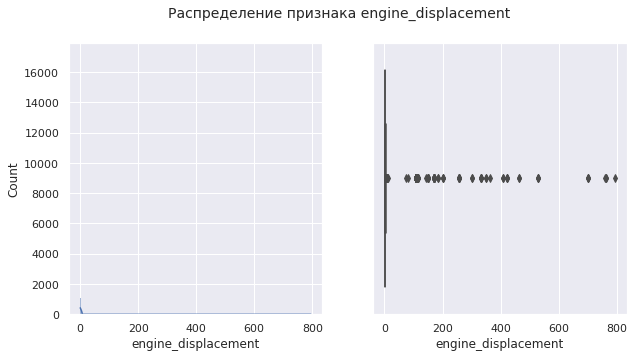

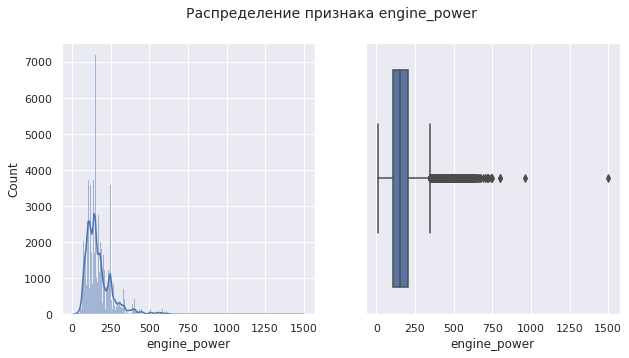

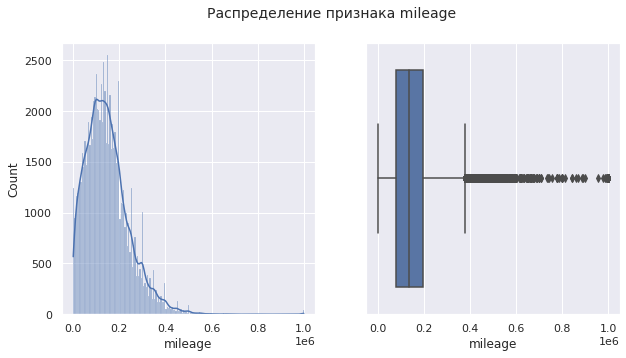

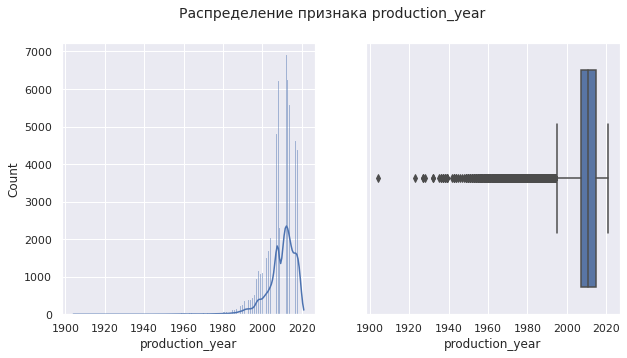

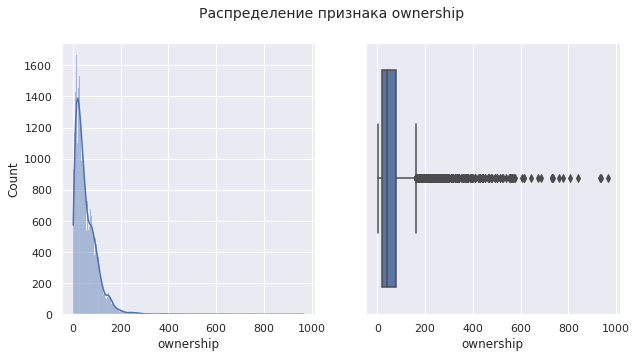

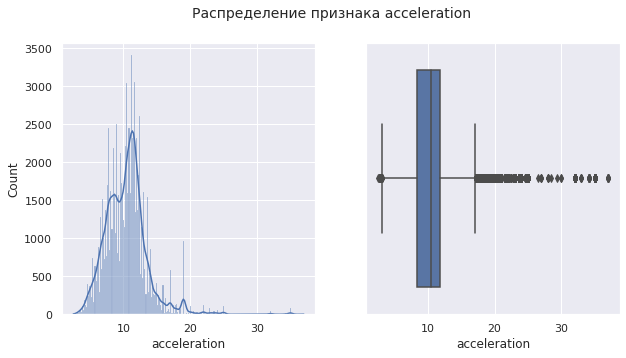

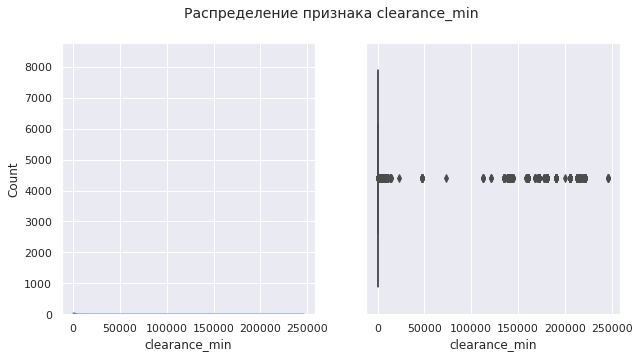

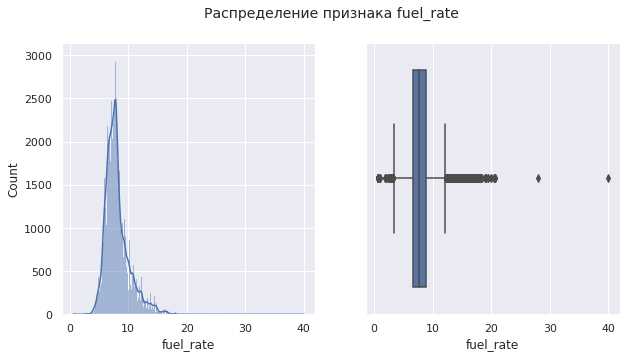

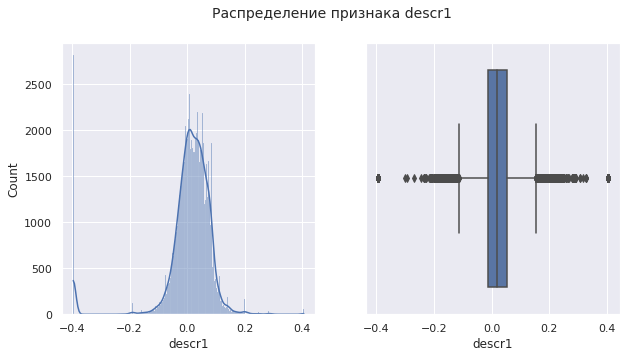

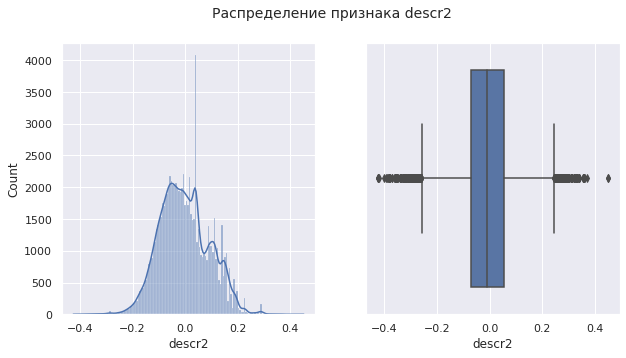

In [212]:
for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    fig.suptitle(f"Распределение признака {col}", fontsize=14)
    sns.histplot(x=df[col], kde=True, ax=axes[0])
    sns.boxplot(x=df[col], ax=axes[1])

#### Описания признаков
- *engine_displacement* (объем двигателя): распределение сильно смещено вправо, т.к. у электроавтомобилей существенно больше объем двигателя, в дальнейшем логарифмируем данный признак. 75% автомобилей имеют не более 2.5 л, в то время как максимальное значение - 795 л
- *engine_power* (мощность двигателя): данное распределение уже не так сильно смещено, но его мы также логарфируем. Автомобили в нашей выборке имеют от 8 л.с., большая часть - не более 200 л.с., но есть экземпляры в том числе и до 1500 л.с.
- *mileage* (пробег): данный признак имеет распределение, похожее на нормальное. Среднее значение пробега составляет 150 тыс. км, в то время как максимальный показатель - 1 млн. км
- *production_year* (год производства автомобиля): самый раритетный автомобиль - 1904 года. Основная часть - начиная с 1990 года и до 2021
- *ownership* (время владения автомобилем, мес): также распределение смещено вправо, будем его логарифмировать. Минимальное время владения - 1 месяц, медианное - 41 месяц (3.5 года), максимальное - почти 1000 месяцев (около 80 лет)
- *acceleration* (время разгона до 100 км/ч, с): распределение похоже на нормальное, значения от 2.7 с до 37 с
- *clearance_min* (минимальный дорожный просвет, мм): основные значения признака от 78 до 300 мм (99% выборки), остальные значения будем считать выбросами, т.к. таких больших значений клиренса не бывает, возможно были какие-то ошибки при парсинге
- *fuel_rate* (расход топлива, л/100км): распределение похоже на нормальное, значения от 0.6 до 40
- *descr1* (числовая характеристика комментария владельца автомобиля, первое число): имеет нормальное распределение со средним значением около 0
- *descr2* (числовая характеристика комментария владельца автомобиля, второе число): имеет нормальное распределение со средним значением около 0

In [213]:
# логарифмируем те признаки, которые планировали
cols_to_log = ["engine_displacement", "engine_power", "ownership"]

for col in cols_to_log:
    df[f"{col}_log"] = np.log(df[col])

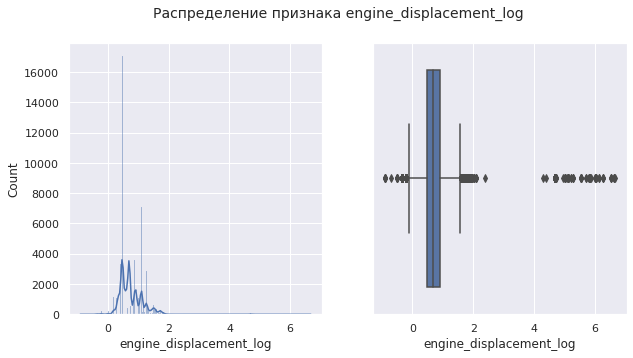

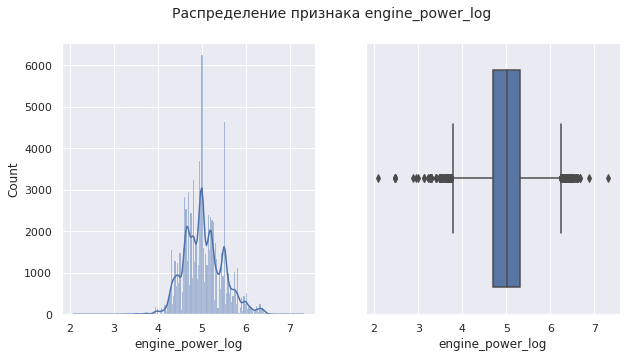

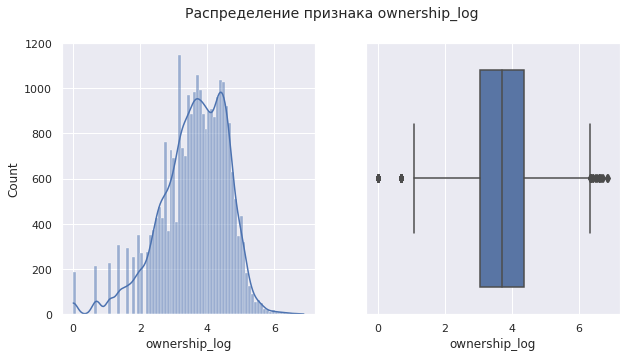

In [214]:
# посмотрим на распределения новых признаков
for col in cols_to_log:
    col = col + "_log"
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    fig.suptitle(f"Распределение признака {col}", fontsize=14)
    sns.histplot(x=df[col], kde=True, ax=axes[0])
    sns.boxplot(x=df[col], ax=axes[1])

In [220]:
# посмотрим, не меньше какого значения клиренса имеют 98% автомобилей
max_clearance = df["clearance_min"].quantile(0.98)
max_clearance

270.0

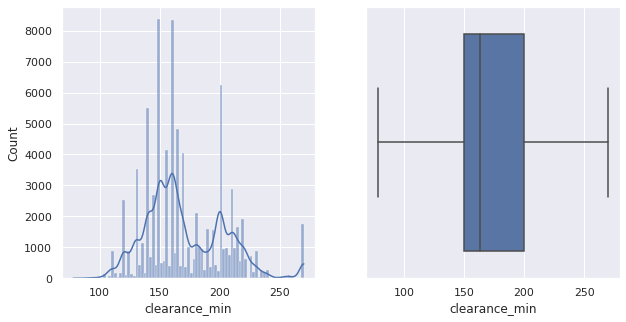

In [221]:
# уберем выбросы и посмотрим на график распределения
df.loc[df["clearance_min"] > max_clearance, "clearance_min"] = max_clearance

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(x=df["clearance_min"], kde=True, ax=axes[0])
sns.boxplot(x=df["clearance_min"], ax=axes[1])

#### Распределение цены автомобиля

In [222]:
df[~df["is_test"]][["price"]].describe()

,price
count,5.051900e+04
mean,1.087653e+06
std,2.275855e+06
min,2.000000e+04
25%,3.400000e+05
50%,6.490000e+05
75%,1.250000e+06
max,2.538148e+08


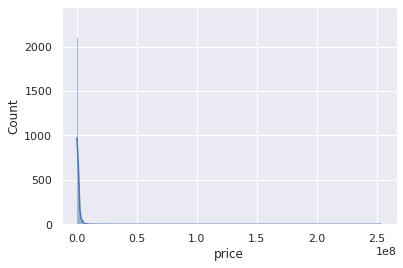

In [223]:
sns.histplot(x=df[~df["is_test"]]["price"], kde=True)

Распределение цены сильно смещено вправо, поэтому логарифмируем признак

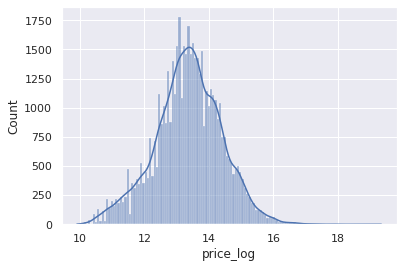

In [224]:
df.loc[~df["is_test"], "price_log"] = np.log(df[~df["is_test"]]["price"])
sns.histplot(x=df[~df["is_test"]]["price_log"], kde=True)

#### Распределение числовых признаков относительно цены

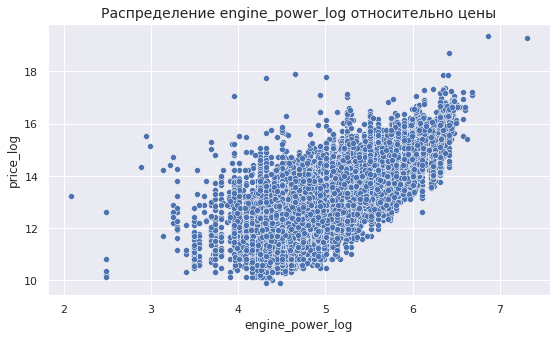

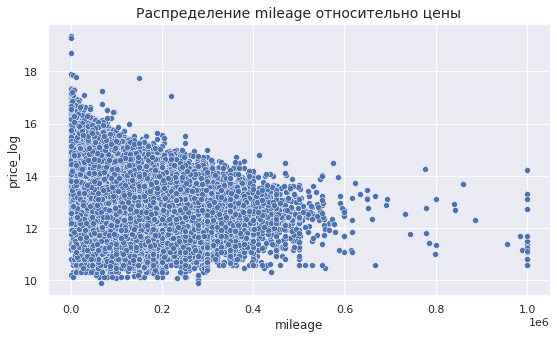

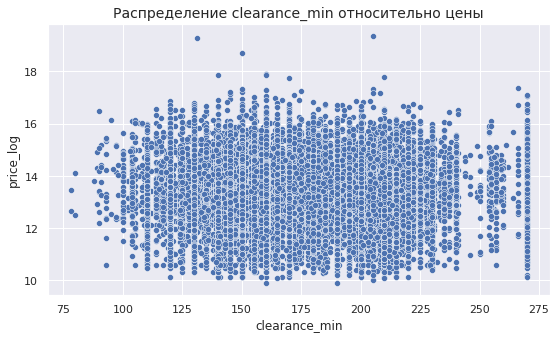

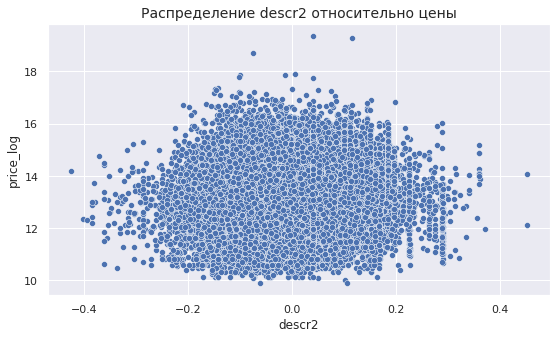

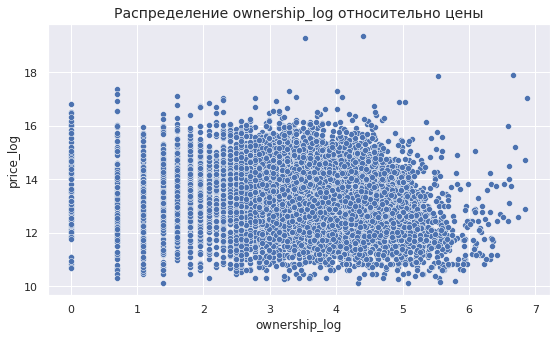

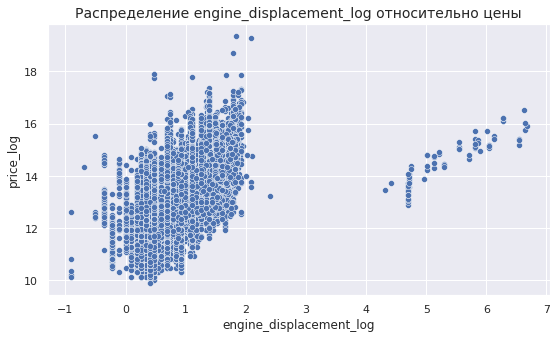

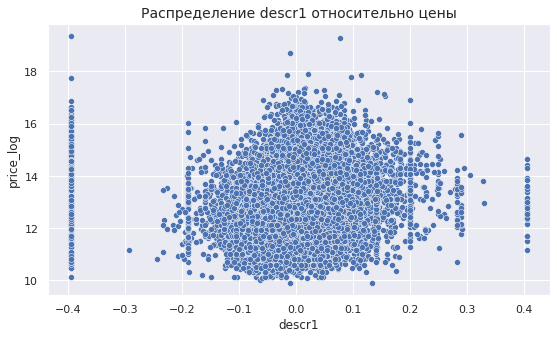

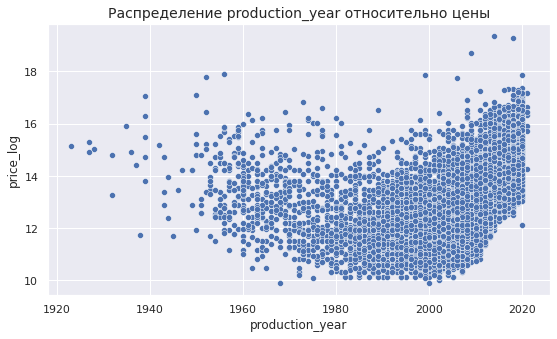

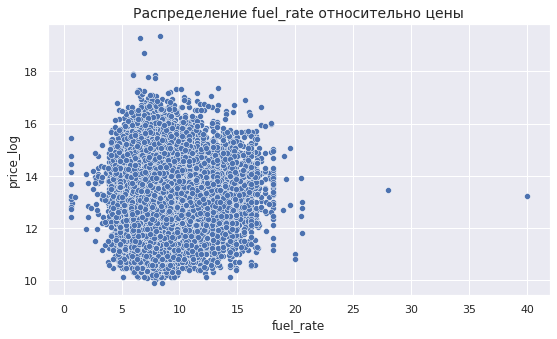

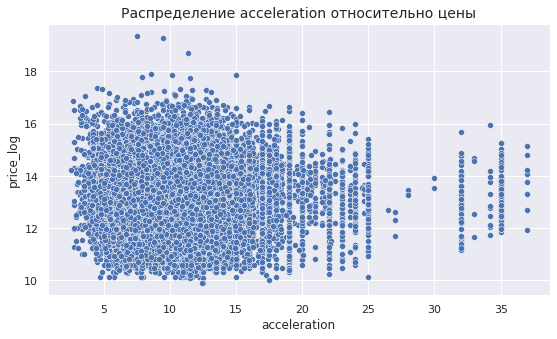

In [225]:
num_cols_upd = list(
    set(num_cols) - set(cols_to_log) | {col + "_log" for col in cols_to_log}
)

for col in num_cols_upd:
    fig, ax = plt.subplots(figsize=(9, 5))

    ax.set_title(f"Распределение {col} относительно цены", fontsize=14)
    sns.scatterplot(x=col, y="price_log", data=df[~df["is_test"]], ax=ax)

#### Выводы:
- *mileage*: с увеличением пробега в среднем уменьшается цена. Это довольно ожидаемо
- *production_year*: самая низкая цена у машин примерно с 1980 до 2000 годов выпусков. Более новые автомобили, выпущенные позже 2000 года, растут в цене по мере увеличения года выпуска. Автомобили, выпущенные ранее 1980 года, растут в цене по мере уменьшения года выпуска. Это может объясняться тем, что машины, выпущенные более давно, ценятся любителями раритетных автомобилей
- *engine_power_log*: с увеличением мощности двигателя увеличивается и цена
- *engine_displacement_log*: тоже правило действует и для объема двигателя. Немного не попадают в этот тренд электроавтомобили, но среди них также действует правило: при увеличении объема двигателя, увеличивается и цена

Остальные признаки заметно не влияют на цену, судя по графикам

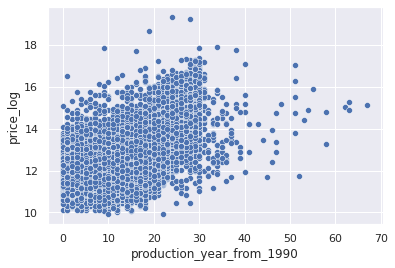

In [226]:
# добавим признак, означающий разницу между годом выпуска и 1990 годом,
# чтобы зависимость стала более линейной
df["production_year_from_1990"] = df["production_year"].apply(
    lambda x: abs(x - 1990)
)
num_cols_upd.append("production_year_from_1990")

sns.scatterplot(x="production_year_from_1990",
                y="price_log",
                data=df[~df["is_test"]])

#### Другие интересные зависимости между признаками

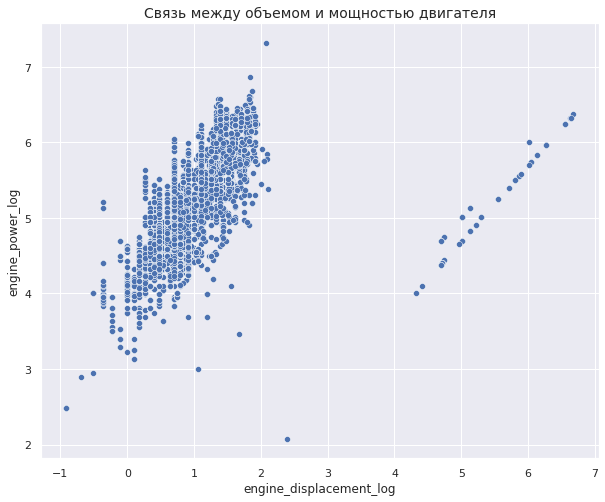

In [227]:
plt.rcParams['figure.figsize'] = (10, 8)

ax = sns.scatterplot(x="engine_displacement_log",
                     y="engine_power_log", data=df)
ax.set_title("Связь между объемом и мощностью двигателя", fontsize=14)
plt.show()

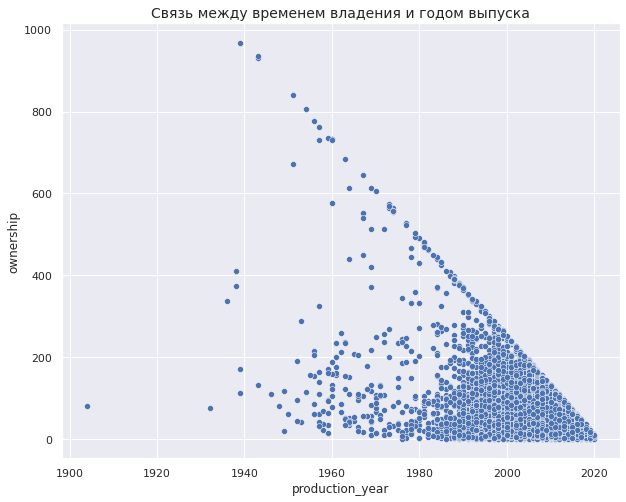

In [228]:
ax = sns.scatterplot(x="production_year", y="ownership", data=df)
ax.set_title("Связь между временем владения и годом выпуска", fontsize=14)
plt.show()

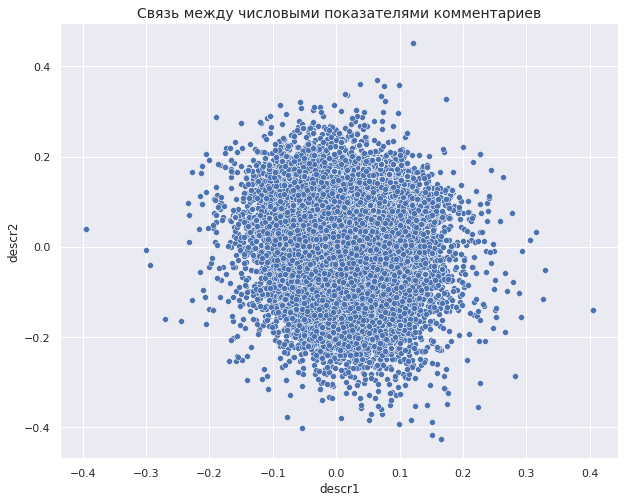

In [229]:
ax = sns.scatterplot(x="descr1", y="descr2", data=df)
ax.set_title("Связь между числовыми показателями комментариев", fontsize=14)
plt.show()

#### Таблица корреляций

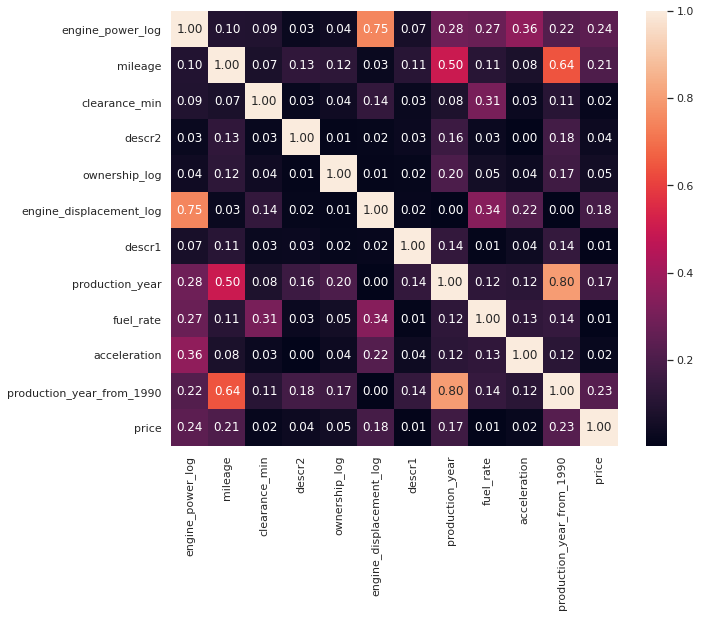

In [230]:
sns.heatmap(np.abs(df[num_cols_upd + ["price"]].corr()), annot=True, fmt=".2f")

Значения цены больше всего скоррелированы с мощностью двигателя (0.24), годом производства машины (0.23), пробегом (0.21) и объемом двигателя (0.18). Среди числовых признаков наиболее скоррелированы между собой: год производства и разница между годом производства и 1990 годом (0.80), объем и мощность двигателя (0.75), пробег и год производства машины (0.64)

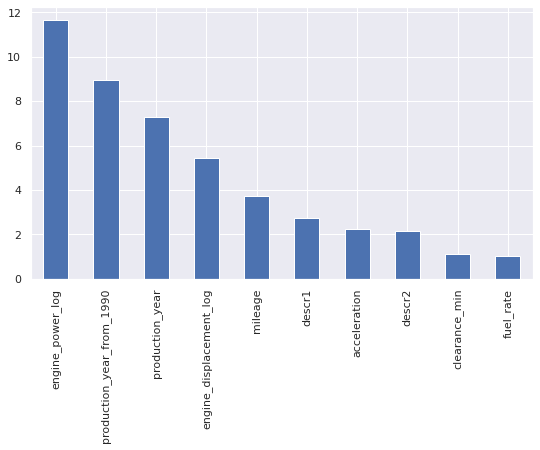

In [231]:
plt.rcParams['figure.figsize'] = (9, 5)
cols = list(set(num_cols_upd) - {"ownership_log"})

# используем дисперсионный анализ ANOVA для определения значимости числовых признаков
imp_num = pd.Series(f_classif(df[cols], df["price"])[0], index=cols)
imp_num.sort_values(inplace=True, ascending=False)
imp_num.plot(kind="bar")

Основываясь на результатах дисперсионного анализа, можно сказать, что все числовые признаки оказывают влияние на цену

### Категориальные признаки

#### Распределения признаков

In [232]:
df[cat_cols].describe(include=["O"])

,body_type,brand,color,fuel_type,model_name,name,price_currency,vehicle_transmission,vendor,vehicle_passport,drive,steering_wheel,condition,customs
count,85205,85205,85205,85205,85205,85205,85205,85205,85205,85205,85205,85205,85205,85205
unique,27,134,16,8,1574,4959,1,4,4,2,3,2,2,1
top,седан,BMW,чёрный,бензин,OCTAVIA,1.6 AT (110 л.с.),RUB,автоматическая,EUROPEAN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
freq,30609,7349,23695,71557,2207,1132,85205,44334,46476,74648,43371,83053,85202,85205


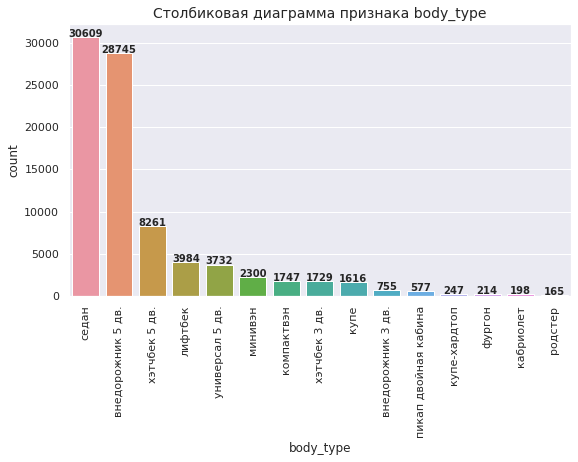

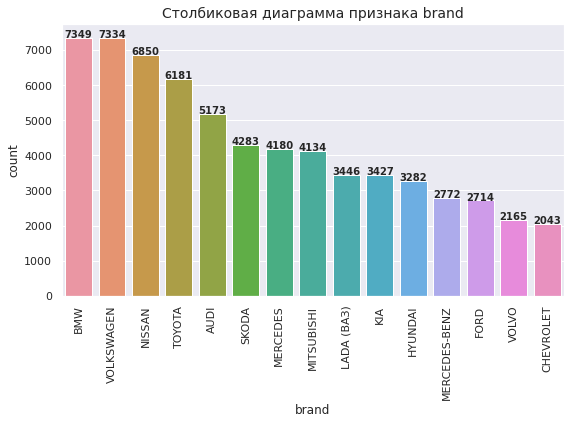

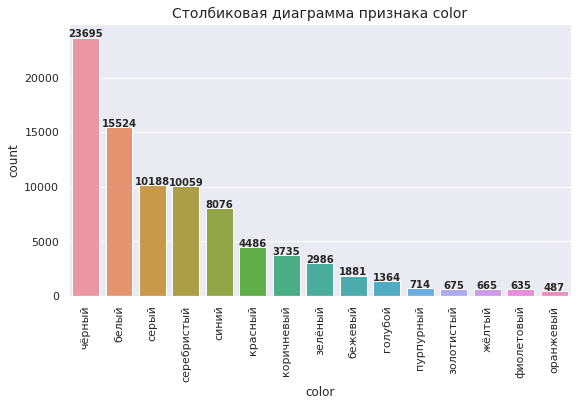

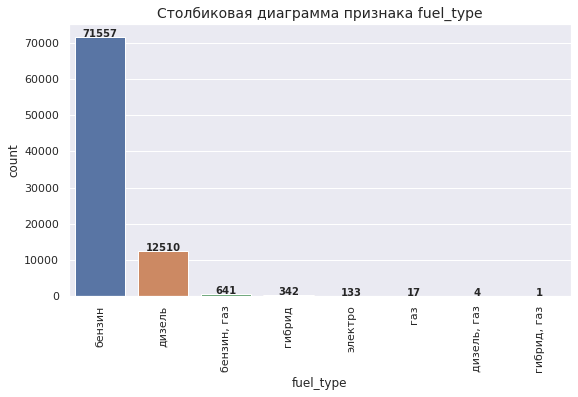

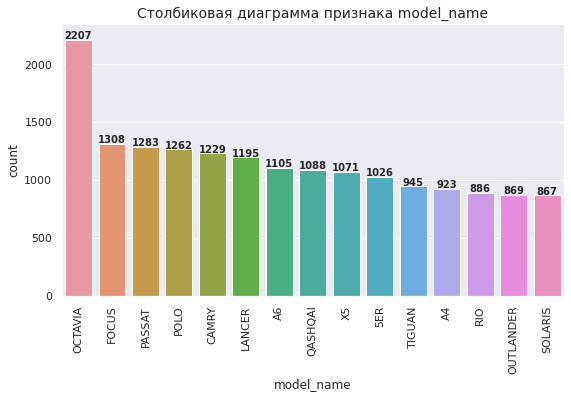

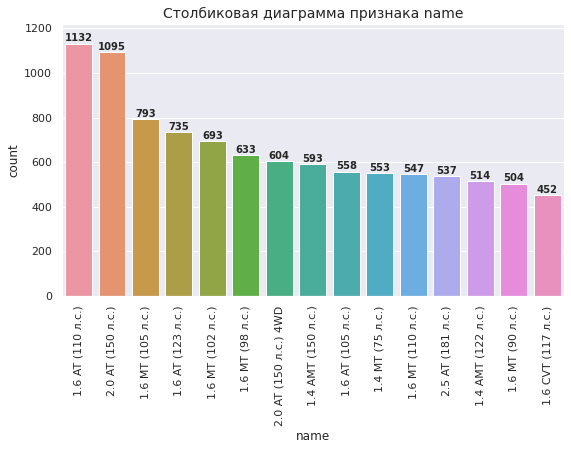

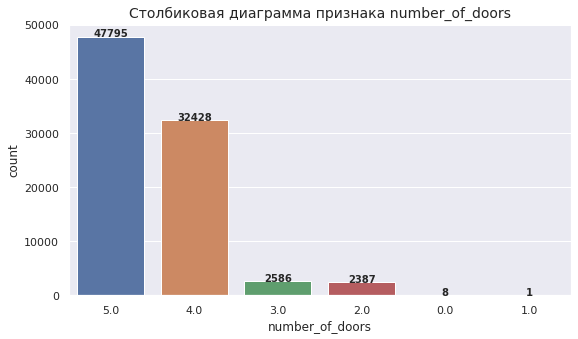

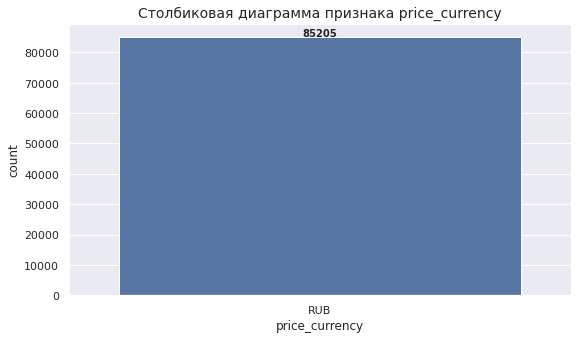

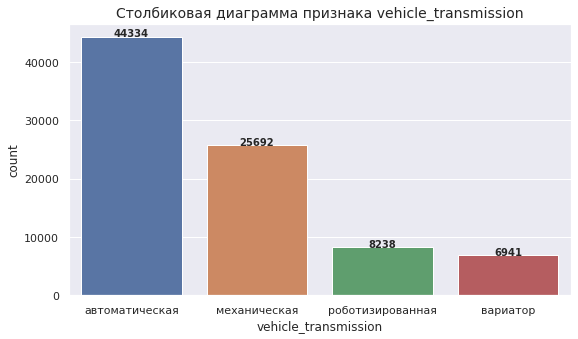

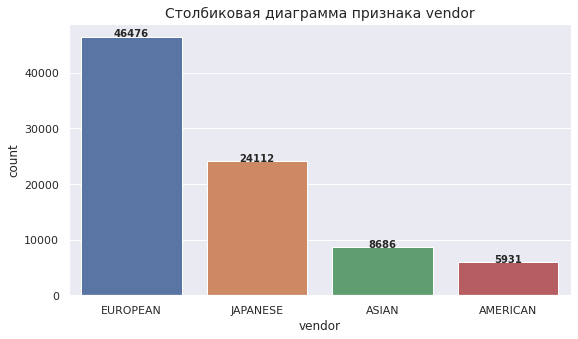

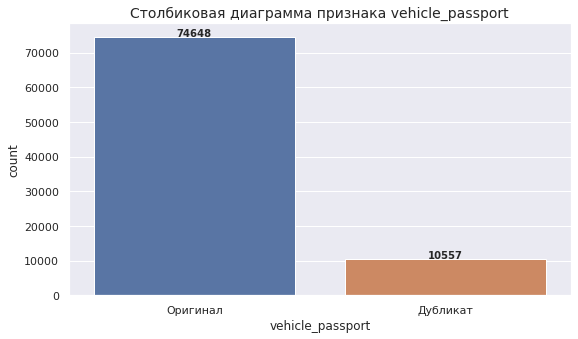

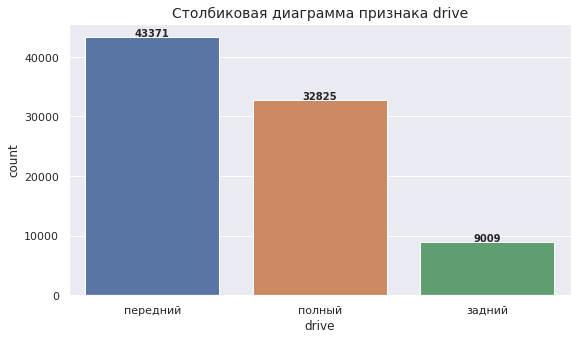

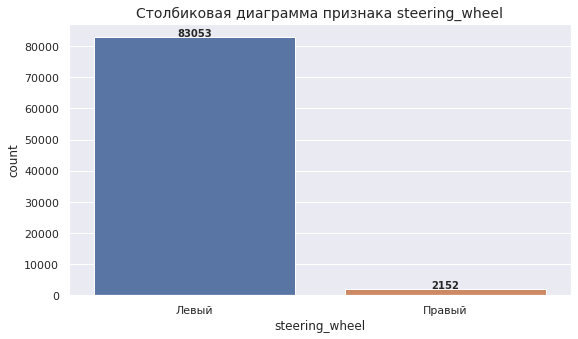

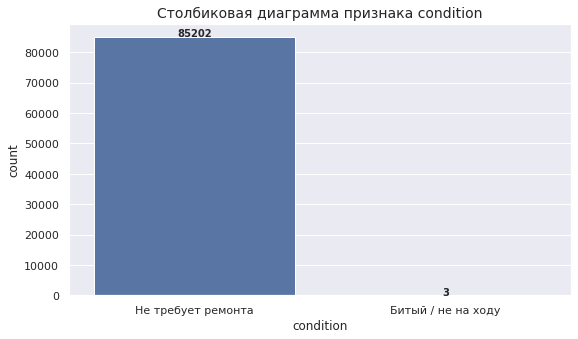

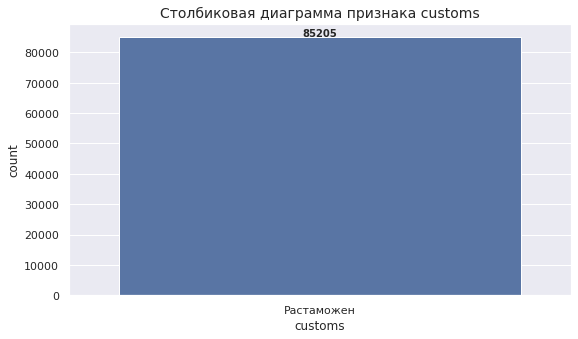

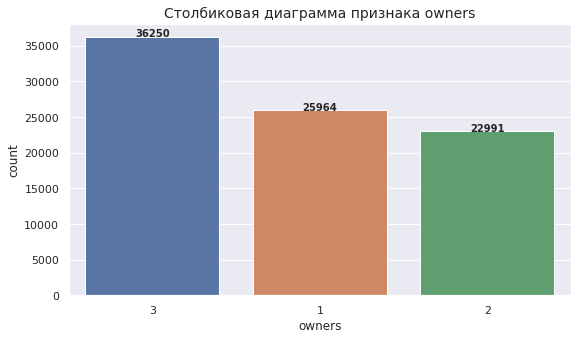

In [233]:
for col in cat_cols:
    values = df[col].value_counts().index[:15]

    # определим, нужно ли поворачивать подписи у графика
    chars_in_fig = 65
    n_values = len(values)
    max_value_length = max([len(str(value)) for value in values])
    rotation = 90 if chars_in_fig / n_values < max_value_length else 0

    plt.xticks(rotation=rotation)
    plt.title(f"Столбиковая диаграмма признака {col}", fontsize=14)
    ax = sns.countplot(x=df[col], order=values)
    ax.set_ylim([0, ax.get_ylim()[1] + 30])

    for rect in ax.patches:
        x = rect.xy[0] + rect.get_width()/2
        y = rect.xy[1] + rect.get_height() + 10
        ax.text(x, y, rect.get_height(),
                horizontalalignment='center', fontsize=10, fontweight="bold")
    plt.show()

Два наших признака имеют только по единственному значению: price_currency и customs. Это значит, что они никак не влияют на цену машину и поэтому они нам не нужны для построения модели.

In [234]:
cat_cols.remove("price_currency")
cat_cols.remove("customs")

#### Распределение цены относительно категориальных признаков

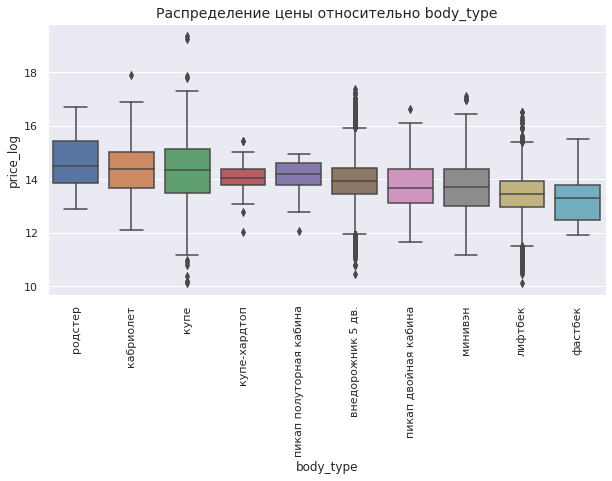

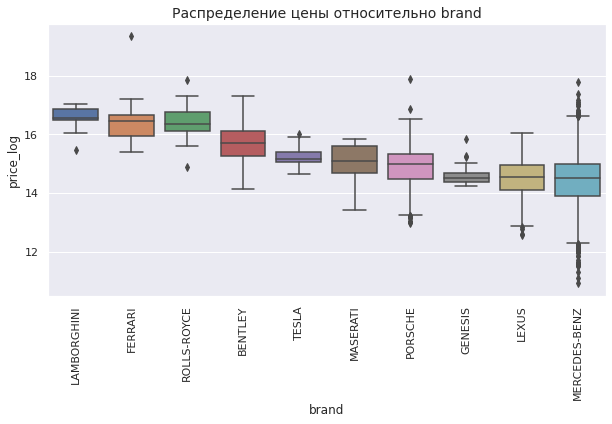

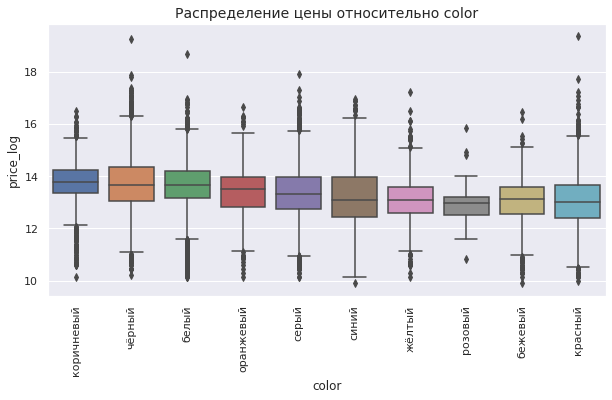

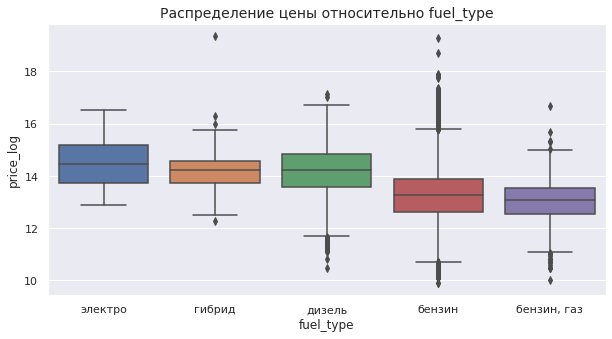

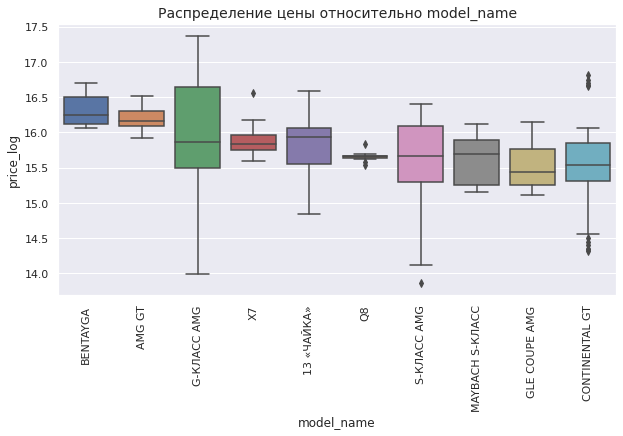

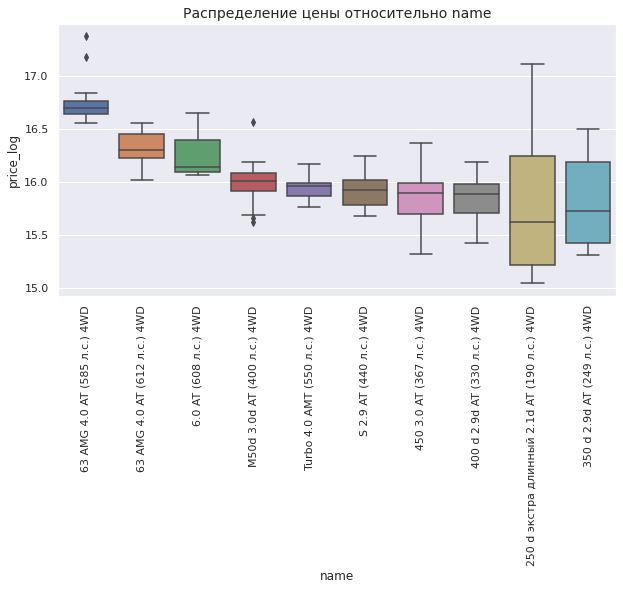

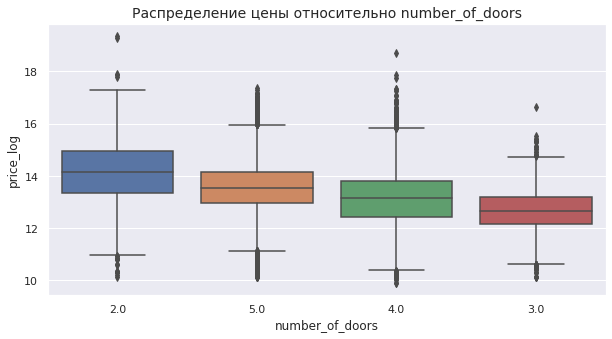

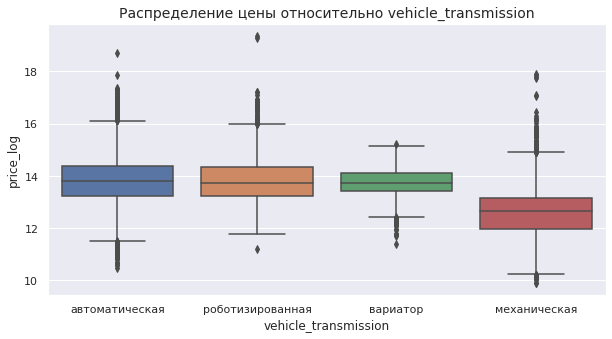

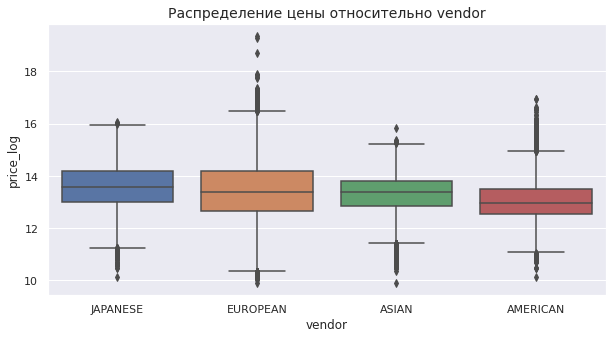

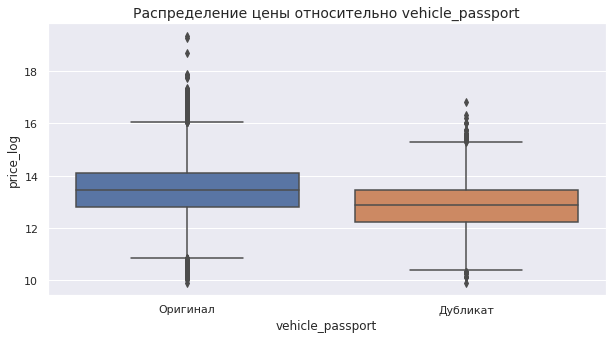

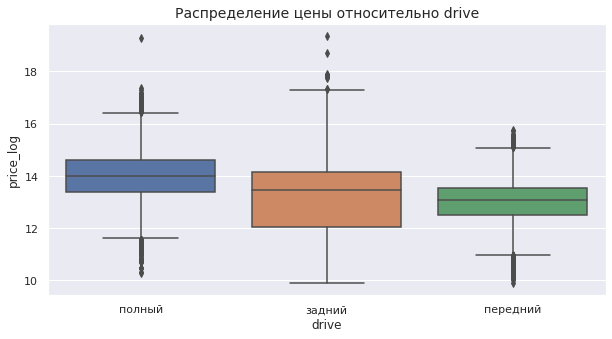

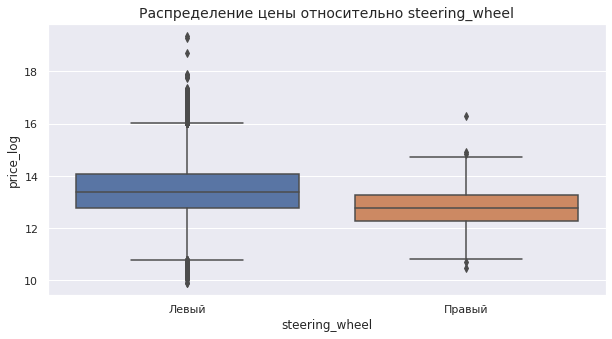

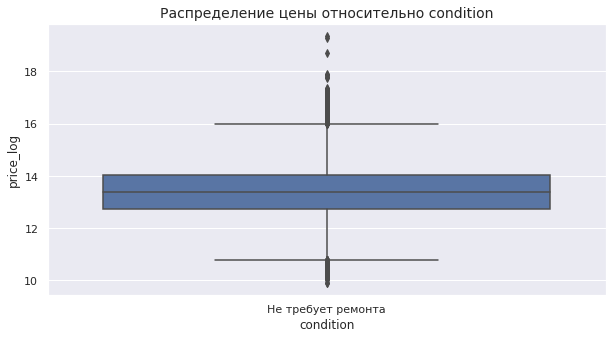

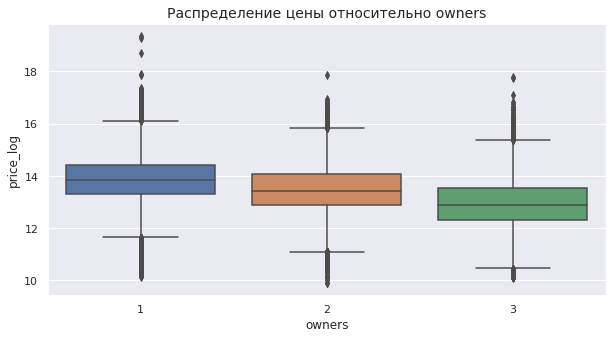

In [235]:
for col in cat_cols:
    # использую только те категории признака, которые встречаются
    # в датасете больше 10 раз
    grouped = df.groupby(col)["price_log"].aggregate(["count", "mean"])
    values = grouped[grouped["count"] > 10]\
        .sort_values("mean", ascending=False)\
        .index[:10]

    # определим, нужно ли поворачивать подписи у графика
    chars_in_fig = 65
    n_values = len(values)
    max_value_length = max([len(str(value)) for value in values])
    rotation = 90 if chars_in_fig / n_values < max_value_length else 0

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.xticks(rotation=rotation)

    ax.set_title(f"Распределение цены относительно {col}", fontsize=14)
    sns.boxplot(x=col, y="price_log", data=df, ax=ax, order=values)
    plt.show()

In [236]:
df[cat_cols].head(1)

,body_type,brand,color,fuel_type,model_name,name,number_of_doors,vehicle_transmission,vendor,vehicle_passport,drive,steering_wheel,condition,owners
0,лифтбек,SKODA,синий,бензин,OCTAVIA,1.2 AMT (105 л.с.),5.0,роботизированная,EUROPEAN,Оригинал,передний,Левый,Не требует ремонта,3


In [237]:
# только два признака среди категориальных представлены в виде чисел
# остальные, кроме бинарных, нужно перекодировать с помощью One Hot Encoder
bin_cols = ["vehicle_passport", "steering_wheel", "condition"]
cat_num_cols = ["number_of_doors", "owners"]
cat_cols_to_encode = list(set(cat_cols) - set(cat_num_cols) - set(bin_cols))

# скопируем датафрейм, чтобы избежать изменения оригинального датафрейма
df_copy = df.copy()

# у трех признаков количество уникальных значений больше 100
# при их кодировании получится слишком много колонок
# поэтому ограничим количество уникальных значений у этих признаков
for col in ["brand", "model_name", "name"]:
    remaining_values = df[col].value_counts().index[:99]
    df_copy.loc[~df_copy[col].isin(remaining_values), col] = "other"

cat_cols_encoded = pd.get_dummies(df_copy[cat_cols_to_encode])

In [238]:
# бинарные признаки преобразуем в числовые
df["vehicle_passport_is_original"] = df["vehicle_passport"]\
    .replace({"Оригинал": 1, "Дубликат": 0})
df["steering_wheel_is_left"] = df["steering_wheel"]\
    .replace({"Левый": 1, "Правый": 0})
df["condition_is_good"] = df["condition"].replace({
    "Не требует ремонта": 1,
    "Битый / не на ходу": 0
})
bin_cols = ["vehicle_passport_is_original",
            "steering_wheel_is_left",
            "condition_is_good"]
bin_cols_encoded = df[bin_cols]

In [239]:
# объединим все категориальные признаки в один датафрейм
cat_cols_encoded = pd.concat([cat_cols_encoded,
                              bin_cols_encoded,
                              df[cat_num_cols]],
                             axis=1)

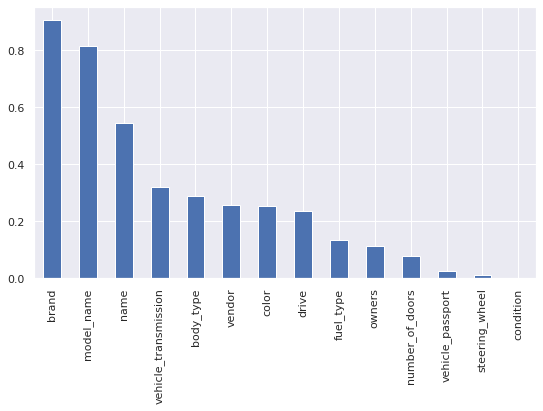

In [240]:
# определим значимость категориальных и бинарных признаков
imp_cat = pd.Series(mutual_info_classif(cat_cols_encoded, df["price"],
                                        discrete_features=True),
                    index=cat_cols_encoded.columns)

# для наглядности объединим значимость признаков,
# используя колонки до one-hot кодирования
imp_dict = {}

for col in cat_cols:
    imp_dict[col] = imp_cat[imp_cat.index.str.startswith(col)].sum()

imp_cat_ovr = pd.Series(imp_dict)

imp_cat_ovr.sort_values(inplace=True, ascending=False)
imp_cat_ovr.plot(kind="bar")

Больше всего влияют на цену автомобиля марка и модель автомобиля, практически не влияет положение руля и состояние машины

In [241]:
# объединим категориальные и числовые признаки в один датафрейм
df_encoded = pd.concat([df[num_cols_upd + ["is_test", "price_log", "price"]],
                        cat_cols_encoded],
                       axis=1)

### Заполнение пропусков признака ownership

In [242]:
# разделим выборку на две подвыборки: обучающую и ту, в которой необходимо
# заполнить пропуски в обучающую выборку включаю только данные из главной
# обучающей выборки, чтобы избежать утечки данных
df_train = df_encoded.loc[(~df_encoded["is_test"])
                          & (~pd.isna(df_encoded["ownership_log"]))]
df_to_fill = df_encoded.loc[pd.isna(df_encoded["ownership_log"])]

In [243]:
# для заполнения пропусков будем использовать случайный лес
# этот алгоритм не требует стандартизации признаков
cols_to_drop = ["ownership_log", "is_test", "price_log", "price"]
X, y = df_train.drop(cols_to_drop, axis=1), df_train["ownership_log"]
X_to_fill = df_to_fill.drop(cols_to_drop, axis=1)

# используя гиперпараметры по умолчанию, обучим алгоритм на всей обучающей выборке
rf = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED)
rf.fit(X, y)
y_pred = rf.predict(X_to_fill)

In [244]:
# заполним пропуски
df_encoded.loc[pd.isna(df_encoded["ownership_log"]), "ownership_log"] = y_pred

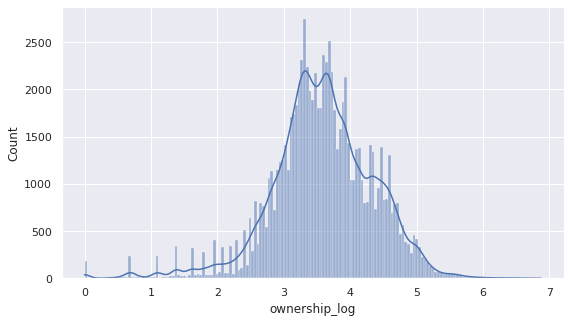

In [245]:
# посмотрим на распределение признака после заполнения пропусков
sns.histplot(x=df_encoded["ownership_log"], kde=True);

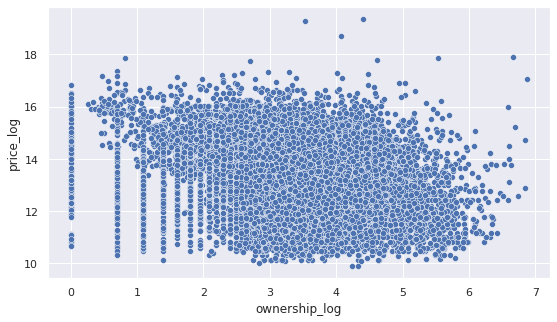

In [246]:
sns.scatterplot(x="ownership_log", y="price_log", data=df_encoded)

In [334]:
# разделим обратно датасет на тестовую и обучающую часть
df_train_encoded = df_encoded.loc[~df_encoded["is_test"]].drop(
    "is_test", axis=1)
df_test_encoded = df_encoded.loc[df_encoded["is_test"]].drop(["is_test",
                                                              "price_log",
                                                              "price"],
                                                             axis=1)

In [278]:
def split_df_to_feats_and_target(df, *, target_is_log=True):
    """Разделяет датасет на признаки и таргет"""
    target_name = "price_log" if target_is_log else "price"
    X, y = df.drop(["price", "price_log"], axis=1), df[target_name]

    return X, y

## Выбор лучшей модели

In [432]:
# создадим функцию для подсчета MAPE, т.к. ее пока нет в версии sklearn для Anaconda
def mean_absolute_percentage_error(y_true, y_pred, *, round=False):
    """
    Считает среднюю абсолютную ошибку в процентах, предварительно 
    возведя массивы в степень e
    """
    if type(y_true).__name__ not in ["ndarray", "Series"] or \
            type(y_pred).__name__ not in ["ndarray", "Series"]:
        raise TypeError("Arguments should be numpy arrays or pandas series")
    if y_true.ndim > 1 or y_pred.ndim > 1:
        raise TypeError("Arguments should be 1-dimensional numpy arrays")
    if y_true.shape != y_pred.shape:
        raise TypeError("Arguments should be of equal length")

    y_true, y_pred = np.exp(y_true), np.exp(y_pred)

    if round:
        y_pred = np.round(y_pred / 1000) * 1000

    error = np.sum(np.abs(y_true - y_pred) / y_true) / y_true.shape[0]

    return error

In [435]:
def evaluate_model(model, X, y, *, standardize=False, round=False):
    """
    Оценивает модель, используя метрику MAPE

    @param model: модель, которую нужно оценить
    @param X: матрица или датафрейм с признаками
    @param y: вектор или объект Series со значениями таргета
    @param standardize: нужно ли стандартизировать признаки перед обучением модели

    @returns: модель и значения ошибок на обучающей и тестовой выборках
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        random_state=RANDOM_SEED)

    if standardize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    return (
        mean_absolute_percentage_error(y_train, y_train_pred, round=round),
        mean_absolute_percentage_error(y_test, y_test_pred, round=round)
    )

In [280]:
# создадим скорер для cross_val_score функции
mape_scorer = make_scorer(mean_absolute_percentage_error,
                          greater_is_better=False)

### Без подбора гиперпараметров

In [282]:
model_evals = {"w/out tuning": {}}

In [283]:
# изначально используем логарифм цены как таргет
X, y = split_df_to_feats_and_target(df_train_encoded)

In [284]:
# линейная регрессия без регуляризации
lr = LinearRegression()
error_train_lr, error_test_lr = evaluate_model(lr, X, y)
model_evals["w/out tuning"]["lr"] = error_train_lr
error_train_lr, error_test_lr

(0.20270482339671111, 0.2018655487389348)

При использовании модели простой линейной регрессии, на тестовой выборке ошибка даже немного меньше, чем на обучающей

In [285]:
# линейная регрессия с регуляризацией ElasticNet
en = ElasticNet(random_state=RANDOM_SEED)
error_train_en, error_test_en = evaluate_model(en, X, y, standardize=True)
model_evals["w/out tuning"]["en"] = error_test_en
error_train_en, error_test_en

(0.8981377638263305, 0.9036595832919316)

При добавлении регуляризации, у нас недообучение, результаты очень плохие

In [286]:
# случайный лес
rf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)
error_train_rf, error_test_rf = evaluate_model(rf, X, y)
model_evals["w/out tuning"]["rf"] = error_test_rf
error_train_rf, error_test_rf

(0.061314235366262425, 0.1689299175722404)

Случайный лес с гиперпараметрами по умолчанию переобучается, но даже в этом случае показывает хороший результат

In [287]:
# градиентный бустинг
gb = GradientBoostingRegressor(random_state=RANDOM_SEED)
error_train_gb, error_test_gb = evaluate_model(gb, X, y)
model_evals["w/out tuning"]["gb"] = error_test_gb
error_train_gb, error_test_gb

(0.22590260238716794, 0.2302851021834272)

Градиентный бустинг немного переобучился

In [288]:
pd.DataFrame(model_evals)

,w/out tuning
en,0.903660
gb,0.230285
lr,0.202705
rf,0.168930


В итоге, без подбора гиперпараметров лучше всех справился случайный лес, хуже всех - линейная регрессия с регуляризацией с параметрами по умолчанию

### Удаление наименее значимых признаков

Для определения значимости признаков будем использовать две модели: случайного леса и градиентного бустинга.

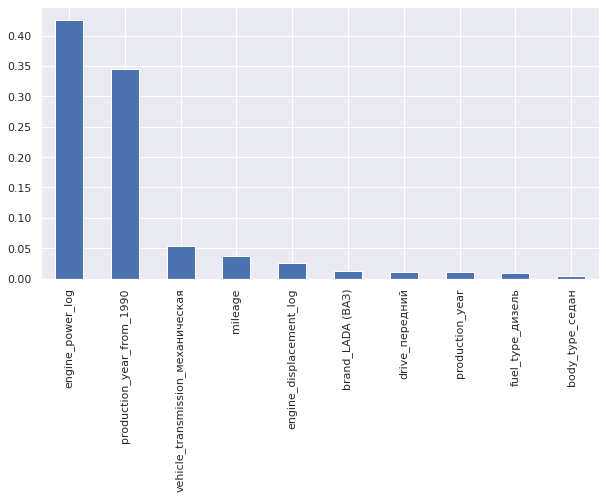

In [289]:
# наиболее важные признаки
feat_imp = pd.Series((rf.feature_importances_ + gb.feature_importances_) / 2,
                     index=X.columns)
feat_imp.sort_values(ascending=False, inplace=True)
feat_imp[:10].plot(kind="bar", figsize=(10, 5))

In [290]:
# посмотрим на количество признаков, которые можно оставить, при значениях порога
# кумулятивной значимости признаков от 90 до 100%
feat_imp_cum = feat_imp.cumsum()
thresholds = list(np.arange(0.9, 1.01, 0.01))
feats_per_threshold = {}

for threshold in thresholds:
    feats_per_threshold[threshold] = feat_imp_cum[feat_imp_cum <= threshold]\
        .shape[0]

feats_per_threshold = pd.Series(feats_per_threshold)
feats_per_threshold

0.90      5
0.91      6
0.92      7
0.93      8
0.94     10
0.95     14
0.96     18
0.97     23
0.98     30
0.99     56
1.00    378
dtype: int64

Считаю оптимальным будет оставить 56 признаков. Кол-во признаков уменьшится более чем в 6 раз и тем самым существенно уменьшится время обучения и при этом 99% общей значимости признаков сохранится

In [335]:
n_cols_to_drop = feats_per_threshold.iloc[-2]
cols_to_drop = feat_imp.index[n_cols_to_drop:]
df_train_encoded.drop(cols_to_drop, axis=1, inplace=True)
df_test_encoded.drop(cols_to_drop.values, axis=1, inplace=True)

df_train_encoded.shape, df_test_encoded.shape

((50519, 58), (34686, 56))

In [336]:
# обновим признаки и таргет
X, y = split_df_to_feats_and_target(df_train_encoded)

### Без подбора гиперпараметров (с меньшим кол-вом признаков)

In [337]:
model_evals["reduced_cols"] = {}

In [338]:
# линейная регрессия
lr_reduced = LinearRegression()
error_train_lr_reduced, error_test_lr_reduced = evaluate_model(lr_reduced, X, y)
model_evals["reduced_cols"]["lr"] = error_train_lr_reduced
error_train_lr_reduced, error_test_lr_reduced

(0.24625883745748925, 0.2451770329031714)

In [339]:
# линейная регрессия с регуляризацией ElasticNet
en_reduced = ElasticNet(random_state=RANDOM_SEED)
error_train_en_reduced, error_test_en_reduced = evaluate_model(
    en_reduced, X, y, standardize=True)
model_evals["reduced_cols"]["en"] = error_test_en_reduced
error_train_en_reduced, error_test_en_reduced

(0.8981377638263305, 0.9036595832919316)

In [340]:
# случайный лес
rf_reduced = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)
error_train_rf_reduced, error_test_rf_reduced = evaluate_model(
    rf_reduced, X, y)
model_evals["reduced_cols"]["rf"] = error_test_rf_reduced
error_train_rf_reduced, error_test_rf_reduced

(0.06362127773159237, 0.1763976992886181)

In [341]:
# градиентный бустинг
gb_reduced = GradientBoostingRegressor(random_state=RANDOM_SEED)
error_train_gb_reduced, error_test_gb_reduced = evaluate_model(
    gb_reduced, X, y)
model_evals["reduced_cols"]["gb"] = error_test_gb_reduced
error_train_gb_reduced, error_test_gb_reduced

(0.22556871068632728, 0.230515394659229)

In [342]:
pd.DataFrame(model_evals)

,w/out tuning,reduced_cols,with tuning
lr,0.202705,0.246259,NaN
en,0.903660,0.903660,0.811075
rf,0.168930,0.176398,NaN
gb,0.230285,0.230515,NaN


В результате уменьшения размерности нашего датасета ошибка модели линейной регрессии существенно увеличилась, у модели случайного леса ошибка увеличилась незначительно, у модели линейной регрессии с регуляризацией точность не изменилась. Градиентный бустинг показал примерно такой же результат

### С подбором гиперпараметров

In [343]:
model_evals["with tuning"] = {}

In [344]:
# игнорируем предупреждения, которые будут возникать
# при использовании кэша в sklearn.pipeline
filterwarnings("ignore", message="Persisting input arguments",
               module="sklearn")

In [345]:
# для поиска лучших гиперпараметров используем только 10000 объявлений,
# чтобы сократить время поиска
X_train_val, _, y_train_val, _ = train_test_split(
    X, y, train_size=10000, random_state=RANDOM_SEED
)

#### Линейная регрессия c регуляризацией (ElasticNet)

In [346]:
def show_errors_based_on_hyperparams(cv, hyperparams):
    """Показывает графики зависимостей ошибки от значения гиперпараметра"""
    cv_results_df = pd.DataFrame(cv.cv_results_)

    for hp in hyperparams:
        plt.title(f"Ошибка в зависимости от параметра {hp}", fontweight="bold")
        sns.scatterplot(x="param_" + hp, y="mean_test_score",
                        data=cv_results_df)
        plt.show()

In [347]:
en_base = ElasticNet(random_state=RANDOM_SEED)
pipeline = make_pipeline(StandardScaler(), en_base)

distributions_en = dict(
    elasticnet__alpha=uniform(loc=0, scale=1),
    elasticnet__l1_ratio=uniform(loc=0.01, scale=0.99)
)

en_cv = RandomizedSearchCV(pipeline, distributions_en, scoring=mape_scorer,
                           verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
en_cv.fit(X_train_val, y_train_val)
print("Лучшие гиперпараметры:")
en_cv.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Лучшие гиперпараметры:


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished


{'elasticnet__alpha': 0.020584494295802447,
 'elasticnet__l1_ratio': 0.9702107536403743}

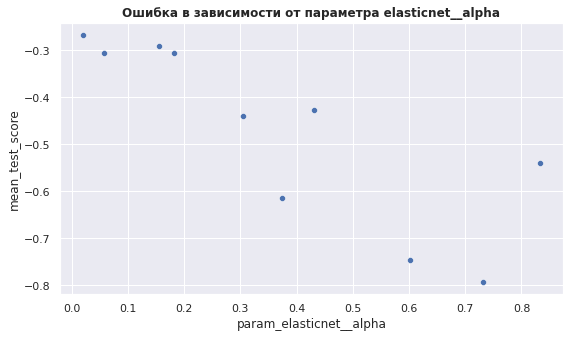

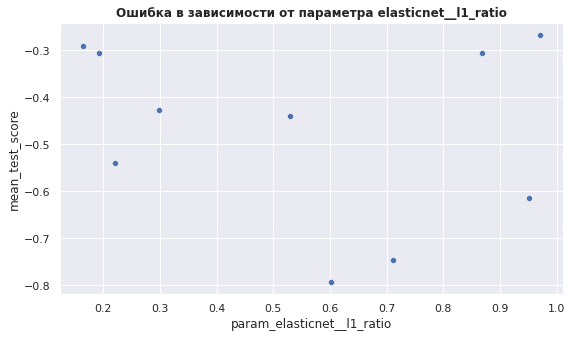

In [348]:
show_errors_based_on_hyperparams(en_cv, distributions_en.keys())

Как видно по графику, чем меньше значение параметра регуляризации, тем меньше ошибка. Это означает, что добаление параметра регуляризации не улучшает нашу модель

In [349]:
best_params = {key.replace("elasticnet__", ""): val
               for key, val in en_cv.best_params_.items()}
en_best = ElasticNet(**best_params, random_state=RANDOM_SEED)
error_train_en_best, error_test_en_best = evaluate_model(en_best, X, y,
                                                         standardize=True)
model_evals["with tuning"]["en"] = error_test_en_best
error_train_en_best, error_test_en_best

(0.2628713971342142, 0.26363323428064706)

In [350]:
model_evals["with tuning"]["en"] = error_test_en_best

#### Случайный лес

In [351]:
rf_base = RandomForestRegressor(random_state=RANDOM_SEED)

distributions_rf = dict(
    n_estimators=randint(90, 150),
    criterion=["mse", "mae"],
    min_samples_split=randint(2, 10),
    min_samples_leaf=randint(1, 7)
)

rf_cv = RandomizedSearchCV(rf_base, distributions_rf, scoring=mape_scorer,
                           verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
rf_cv.fit(X_train_val, y_train_val)
print("Лучшие гиперпараметры:")
rf_cv.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 106.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 121.0min finished


Лучшие гиперпараметры:


{'criterion': 'mse',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 148}

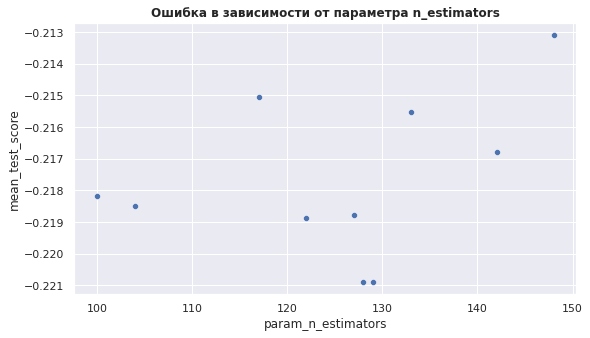

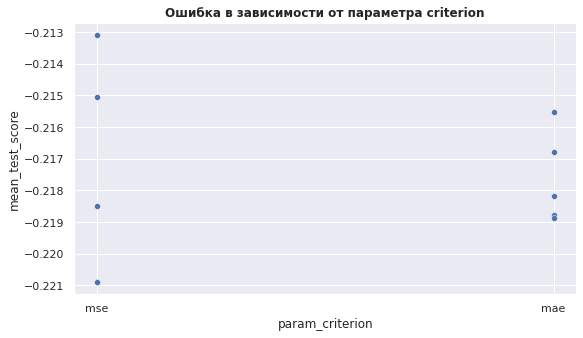

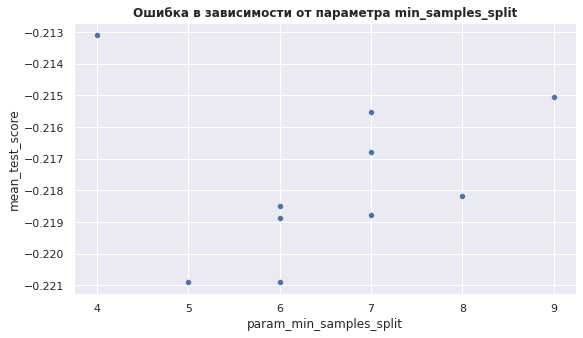

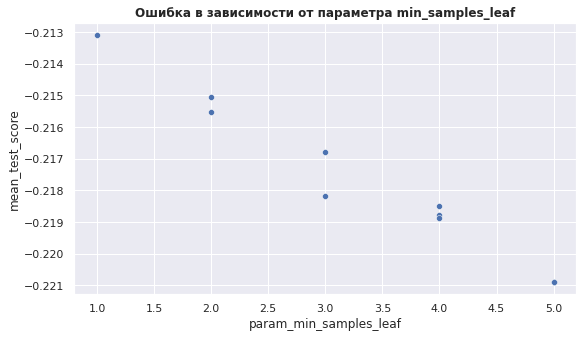

In [352]:
show_errors_based_on_hyperparams(rf_cv, distributions_rf.keys())

In [359]:
rf_best = RandomForestRegressor(**rf_cv.best_params_, random_state=RANDOM_SEED)
error_train_rf_best, error_test_rf_best = evaluate_model(rf_best, X, y,
                                                         standardize=True)
model_evals["with tuning"]["rf"] = error_test_rf_best
error_train_rf_best, error_test_rf_best

(0.06861370222276862, 0.17563986303735055)

#### Градиентный бустинг

In [354]:
gb_base = GradientBoostingRegressor(random_state=RANDOM_SEED)

distributions_gb = dict(
    learning_rate=uniform(loc=0.1, scale=0.1),
    n_estimators=randint(170, 250),
    max_depth=randint(4, 6),
    min_samples_leaf=randint(3, 6)
)

gb_cv = RandomizedSearchCV(gb_base, distributions_gb, scoring=mape_scorer,
                           verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
gb_cv.fit(X_train_val, y_train_val)
print("Лучшие гиперпараметры:")
gb_cv.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.6min finished


Лучшие гиперпараметры:


{'learning_rate': 0.1304242242959538,
 'max_depth': 5,
 'min_samples_leaf': 3,
 'n_estimators': 218}

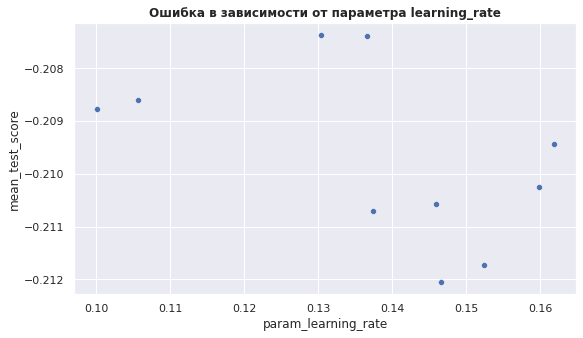

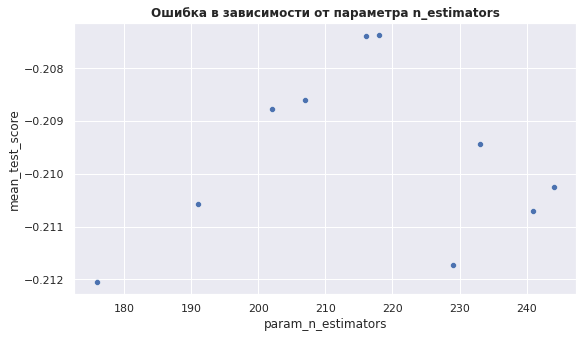

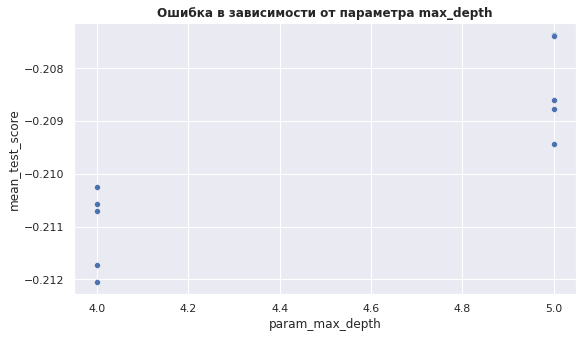

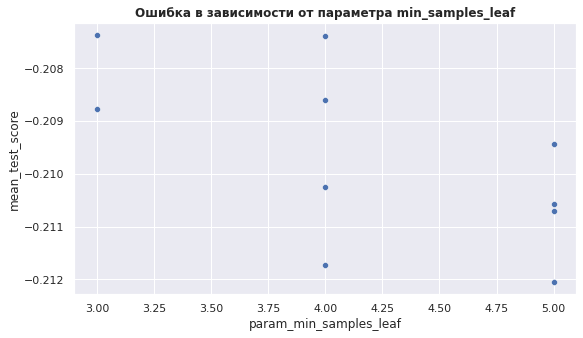

In [355]:
show_errors_based_on_hyperparams(gb_cv, distributions_gb.keys())

In [358]:
gb_best = GradientBoostingRegressor(**gb_cv.best_params_,
                                    random_state=RANDOM_SEED)
error_train_gb_best, error_test_gb_best = evaluate_model(gb_best, X, y,
                                                         standardize=True)
model_evals["with tuning"]["gb"] = error_test_gb_best
error_train_gb_best, error_test_gb_best

(0.16101849538412094, 0.18572820099112664)

In [360]:
pd.DataFrame(model_evals)

,w/out tuning,reduced_cols,with tuning
lr,0.202705,0.246259,NaN
en,0.903660,0.903660,0.263633
rf,0.168930,0.176398,0.175640
gb,0.230285,0.230515,0.185728


В результате тюнинга гиперпараметров заметно улучшился результат алгоритма ElasticNet, довольно сильно улучшился результат градиентного бустинга и совсем немного уменьшилась ошибка случайного леса

In [414]:
rounded_to_thousands = df_train_encoded[df_train_encoded["price"] % 1000 == 0]
rounded_ratio = rounded_to_thousands.shape[0] / df_train_encoded.shape[0]
print("Количество объявлений с ценой автомобиля, округленной до тысячи: "
      f"{rounded_ratio:.2%}")

Количество объявлений с ценой автомобиля округленной до 1000: 97.30%


Большинство объявлений автомобилей с ценой, округленной до тысячи. Посмотрим, как изменится ошибка наших алгоритмов, если мы будем округлять наши предсказания

### С округлением

In [421]:
model_evals["rounded"] = {}

In [436]:
# линейная регрессия
error_train_lr_round, error_test_lr_round = evaluate_model(lr, X, y,
                                                           standardize=True,
                                                           round=True)
model_evals["rounded"]["lr"] = error_test_lr_round
error_train_lr_round, error_test_lr_round

(0.24624644183988142, 0.2451890767505511)

In [437]:
# ElasticNet
error_train_en_round, error_test_en_round = evaluate_model(en_best, X, y,
                                                           standardize=True,
                                                           round=True)
model_evals["rounded"]["en"] = error_test_en_round
error_train_en_round, error_test_en_round

(0.26286948286816825, 0.2636419624061715)

In [438]:
# случайный лес
error_train_rf_round, error_test_rf_round = evaluate_model(rf_best, X, y,
                                                           standardize=True,
                                                           round=True)
model_evals["rounded"]["rf"] = error_test_rf_round
error_train_rf_round, error_test_rf_round

(0.06859809519611645, 0.17564066355894895)

In [439]:
# градиентный спуск
error_train_gb_round, error_test_gb_round = evaluate_model(gb_best, X, y,
                                                           standardize=True,
                                                           round=True)
model_evals["rounded"]["gb"] = error_test_gb_round
error_train_gb_round, error_test_gb_round

(0.16102151988359217, 0.1857136561110062)

In [440]:
pd.DataFrame(model_evals)

,w/out tuning,reduced_cols,with tuning,rounded
lr,0.202705,0.246259,NaN,0.245189
en,0.903660,0.903660,0.263633,0.263642
rf,0.168930,0.176398,0.175640,0.175641
gb,0.230285,0.230515,0.185728,0.185714


После округления результатов предсказаний, ошибка практически осталась прежней

### Стекинг

In [361]:
# разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_SEED
)

# стандартизируем признаки (для алгоритма ElasticNet)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [388]:
def compute_meta_feature(estimator, X_train, X_test, y_train, cv):
    """Вычисляет признак для мета модели"""

    X_meta_train = np.zeros_like(y_train, dtype=np.float32)

    for train_fold_ind, pred_fold_ind in cv.split(X_train):
        X_fold_train = X_train.iloc[train_fold_ind]
        X_fold_pred = X_train.iloc[pred_fold_ind]
        y_fold_train = y_train.iloc[train_fold_ind]

        folded_estimator = clone(estimator)
        folded_estimator.fit(X_fold_train, y_fold_train)
        X_meta_train[pred_fold_ind] = folded_estimator.predict(X_fold_pred)

    meta_estimator = clone(estimator)
    meta_estimator.fit(X_train, y_train)

    X_meta_test = meta_estimator.predict(X_test)

    return X_meta_train, X_meta_test

In [389]:
def generate_metafeatures(estimators, X_train, X_test, y_train, cv):
    """Генерирует признаки для мета модели"""

    features = [
        compute_meta_feature(estimator, X_train, X_test, y_train, cv)
        for estimator in tqdm(estimators)
    ]

    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T

    return stacked_features_train, stacked_features_test

In [393]:
def stack_models(models, X_train=X_train, X_test=X_test,
                 y_train=y_train, y_test=y_test):
    """
    Аггрегирует результаты нескольких моделей и возвращает мета-модель
    и ошибку модели, если известна целевая переменная таргета, в другом 
    случае возращает предсказания
    """
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    features_train, features_test = generate_metafeatures(
        models, X_train, X_test, y_train, cv)

    meta_model = LinearRegression()
    meta_model.fit(features_train, y_train)
    y_pred = meta_model.predict(features_test)

    if y_test is not None:
        error = mean_absolute_percentage_error(y_test, y_pred)
        return meta_model, error

    return y_pred

Попробуем создать мета-модель пятью различными способами и посмотрим, у какой из них будет лучший результат

In [369]:
meta_model1, error1 = stack_models([lr, en_best, rf_best, gb_best])
error1

100%|██████████| 4/4 [08:47<00:00, 131.77s/it]


0.17266193227933166

In [370]:
meta_model2, error2 = stack_models([lr, rf_best, gb_best])
error2

100%|██████████| 3/3 [08:43<00:00, 174.45s/it]


0.1731155708103899

In [371]:
meta_model3, error3 = stack_models([rf_best, gb_best])
error3

100%|██████████| 2/2 [08:46<00:00, 263.41s/it]


0.17319912282881278

In [372]:
meta_model4, error4 = stack_models([lr, rf_best])
error4

100%|██████████| 2/2 [04:46<00:00, 143.29s/it]


0.17414677173986226

In [373]:
meta_model5, error5 = stack_models([lr, gb_best])
error5

100%|██████████| 2/2 [03:52<00:00, 116.20s/it]


0.18551608405591474

Самая лучшая мета-модель оказалась та, которую включает в себя результаты из всех четырех моделей. И так как ее результат оказался лучше, чем у случайного леса, для итогового предсказания попробуем использовать именно эту модель

## Предсказание цены на тестовой выборке

На лидерборде результат стекинга оказался немного хуже, чем результат случайного леса, поэтому все таки остановимся на моделе случайного леса

In [443]:
X, y = split_df_to_feats_and_target(df_train_encoded)
rf_best.fit(X, y)
y_pred = rf_best.predict(df_test_encoded)
y_pred

array([13.42955256, 13.63248413, 13.62543388, ..., 12.61431839,
       14.18325746, 13.97732434])

In [445]:
submission = pd.DataFrame({"sell_id": df_test["sell_id"],
                           "price": np.exp(y_pred)})
submission.to_csv("submission.csv", index=False)
submission.head()

,sell_id,price
0,1100575026,679799.080190
1,1100549428,832746.150137
2,1100658222,826895.726804
3,1100937408,717643.019062
4,1101037972,798993.171008
